<p style="text-align: center; font-size:200%;" size=10>
<span style="color:blue"> City of Tijuana, Metropolitan Transit System analysis</span> </p>
<p style="text-align: center; font-size:150%;" size=10> Transporte Vehicular Metropolitano (TVM) </p>

**Table of contents**:
1. [Libraries](#TVM_LIB).
2. [Experimental hyperparameters](#TVM_HP).
3. [Helper functions](#TVM_HELPER)
4. [Metrics](#TVM_METRICS). 
5. [Data analysis workflow](#TVM_WF).
6. [Data visualization](#TVM_VZ).
7. [Statistical data analysis](#TVM_SDT).
8. [References](#TVM_REF).

**Research tasks**:
- Research metric interpretation.

### <a name="TVM_LIB">1. <span style="color:blue">Libraries</span></a>

In [1]:
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import geojson
import pyproj                            # Utilities
from math import sin,cos,sqrt,asin,pi    # Utilities
from math import radians                 # Utilities
from decimal import *


import networkx as nx                    # Graph modelling see https://networkx.github.io/
import numpy as np
import json

import pandas as pd                      # Metrics
from abc import ABCMeta, abstractmethod  # Metrics


from sklearn.manifold import TSNE        # Statistical data analysis
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

# from sklearn.cluster import DBSCAN       # Clustering
import hdbscan
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt          # Visualization
from matplotlib.pyplot import *
import seaborn as sns

%matplotlib inline

from mpl_toolkits.basemap import Basemap 
import matplotlib.pyplot as plt

### <a name="TVM_HP">2. <span style="color:blue">Experimental hyperparameters</span></a>

The transport routes were edited with [JOSM](https://josm.openstreetmap.de/) Ver. 15238, an extensible editor for Open Street Map. The complete transportation network agregates 104 independent routes, with a total of 20,411 nodes. Routes share 80% of nodes, since they overlap and share intersections, reducing the node dataset to 4,461 unique nodes.  See Fig. 1. 
<br>
<img src="img/image.png" width="600" height="100">
<p style="text-align: center;">**Figure 1.** 104 routes at Tijuana transportation network.</p>
<br>
Six datasets are made available. Datasets with two, six, seven and twenty two routes were used for testing and simple data analysis and visualization. The complete transport network contains  104 independent routes. The  merged route dataset is used in the final analysis (104_routes.geojson). Datasets are in [geojson](https://geojson.org/) formated, an encoding format for geographic data structures. Dataset file names format is as follows ```<number of nodes>M,UM<merged or unmerged>R<number of polygons>P.geojson```.
<br>
<p style="text-align: center;">**Table I.** Tijuana transportation network datasets.</p>

| No. routes | No. polygons | dataset | 
|:--------:|:----------:|:------------|
| 2 | 0 | 2MR0P.geojson |
| 6 | 2 | 6MR2P.geojson |
| 7 | 0 | 7MR0P.geojson |
| 22 | 0 | 22MR0P.geojson |
| 104 | 0 | 104MR0P.geojson |

In [3]:
# hyperparameters   'ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW'
# Node metrics centrality : 'ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC'
# Node metrics clustering : 'NCCO','NCCW','KNN','KNNW'
# Edge metrics:
# Global metrics: 'NLDA','NLD','NGRC','NLT'


hp = {                        #C:\Users\ahiralesc\Datasets\tvm\104MR0P.geojson
    "source_geojson"      : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P.geojson", # TODO: update with your path
    "node_metrics"        : ['ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW'],
    "edge_metrics"        : [ ], #TODO:
    "global_metrics"      : ['NLDA','NLD','NGRC','NLT'], 
    "plot_node_metrics"   : ['ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW'],
    "plot_edge_metrics"   : [ ], #TODO:
    "plot_global_metrics" : ['NLDA','NLD','NGRC','NLT'],
    "persistance"    : { "node_metrics"   : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_node_metrics.cvs",
                         "edge_metrics"   : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_edge_metrics.cvs",
                         "global_metrics" : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_global_metrics.cvs",
                         "dag"            : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_dag.pickle",
                         "node_tsne"      : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_node_tsne.cvs",
                         "edge_tsne"      : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_edge_tsne.cvs",
                         "node_clusters"  : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_node_clus.cvs",
                         "edge_clusters"  : r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\104MR0P_edge_clus.cvs"
                       }
    }



# Replace local paths
#    "persistance"    : { "node_metrics"   : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_metrics.cvs",
#                         "edge_metrics"   : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_metrics.cvs",
#                         "global_metrics" : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_global_metrics.cvs",
#                         "dag"            : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_dag.pickle",
#                         "node_tsne"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_tsne.cvs",
#                         "edge_tsne"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_tsne.cvs",
#                         "node_clusters"  : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_clus.cvs",
#                         "edge_clusters"  : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_clus.cvs"
#                       }
#   }




# Hiperparametros para la visualizacion
options = {
    'node_color' : 'yellow',
    'font_size'  : 7,
    'node_size' : 100,
    'edge_size' : 1,
    'width' : 1,
    'with_labels' : 'True'
}



### <a name="TVM_HELPER">3. <span style="color:blue">Helper functions</span></a>

In [4]:
class TVM_Helper:
    
    def __init__(self):
        pass
    
    
    def locations(self, minVal, maxVal, data, field):
        data = (data[(data[field] >= minVal) & (data[field] <=  maxVal)]["Tupla"])
        locations = [v.split(":") for v in data]
        return locations
    
    
    def cargaRutas(self, trayectoriaArchivo):
        df = dict()
    
        # Carga de persistencia
        with open(trayectoriaArchivo) as f:
            rutas = geojson.load(f)
    
        # Determinar el numero de rutas en el archivo
        for r in range(len(rutas['features'])):
            ruta = rutas['features'][r]
            # Nombre de la ruta
            nombre_ruta = ruta["properties"]['name']
            # Extraer los puntos de cada ruta
            puntos   = ruta['geometry']['coordinates']
            dtype  = ruta['geometry']['type']
            df[nombre_ruta] = [puntos, dtype]
    
        return df


    def concatenaCoordenadas(self, tupla):
        return "%s:%s" % (tupla[1],tupla[0])


    
    def transformaRuta(self, ruta):
        l = list()
        for p in ruta:
            k = self.concatenaCoordenadas(p)
            l.append(k)
        return l


    def obtenVertices(self, df):
        vertices = pd.DataFrame(columns=['Tupla', 'Etiqueta', 'Longitud', 'Latitud'])
        vn = 0
        for k in df.keys():
            if df[k][1] == 'LineString':
                l = self.transformaRuta(df[k][0])
                for vertice in l:
                    if vertice not in vertices['Tupla'].unique():
                        etiqueta = "v%s" % (vn)
                        longitud = float(vertice.split(":")[1])
                        latitud  = float(vertice.split(":")[0])
                        vn = vn + 1
                        vertices = vertices.append({'Tupla' : vertice , 'Etiqueta' : etiqueta,
                                               'Longitud' : longitud, 'Latitud' : latitud} , ignore_index=True)
        # Hacer que la tupla sea el indice de la tabla
        vertices.set_index('Tupla',inplace=True)
        return vertices


    def distanciaEntrePuntos(self, o, d):
        name_ellps = "WGS84"
        geod = pyproj.Geod(ellps=name_ellps)

        lat1 = float(o.split(":")[0])
        long1 = float(o.split(":")[1])
        lat2 = float(d.split(":")[0])
        long2 = float(d.split(":")[1])
   
        grad1,grad2,distancia = geod.inv(long1, lat1, long2, lat2)
        return grad1, grad2, distancia


    def obtenAristas(self, df, vertices):
        # La distancia esta en metros (Dist)
        aristas = pd.DataFrame(columns=['Arista', 'Angulo1', 'Angulo2', 'Dist'])
        for k in df.keys():
            for i in range(len(df[k][0])-1):
                o = self.concatenaCoordenadas(df[k][0][i])
                d = self.concatenaCoordenadas(df[k][0][i+1])
                vo = vertices.loc[[o]]['Etiqueta'][0]
                vd = vertices.loc[[d]]['Etiqueta'][0]
                grad1, grad2, distancia = self.distanciaEntrePuntos(o,d)
                e = (vo,vd)
                aristas = aristas.append({'Arista' : e , 'Angulo1' : grad1, 'Angulo2' : grad2, 'Dist' : distancia} , ignore_index=True)
        return aristas 
    
    
    
    def obtenPoligonos(self, df):
        poligonos = pd.DataFrame(columns=['Nombre', 'Poligono'])
        vn = 0
        for k in df.keys():
            if df[k][1] == 'Polygon':
                poligonos = poligonos.append({'Nombre' : k , 'Poligono' : df[k][0][0]} , ignore_index=True)
        # Hacer que la tupla sea el indice de la tabla
        poligonos.set_index('Nombre',inplace=True)
        return poligonos


    
    def geodetic_a_geocentrica(self, ellipsoid, latitude, longitude, height):
        """ Return geocentric (Cartesian) Coordinates x, y, z corresponding to
            the geodetic coordinates given by latitude and longitude (in
            degrees) and height above ellipsoid. The ellipsoid must be
            specified by a pair (semi-major axis, reciprocal flattening).
            
            Autor: Gareth Rees
        """
        φ = radians(latitude)
        λ = radians(longitude)
        sin_φ = sin(φ)
        a, rf = ellipsoid           # semi-major axis, reciprocal flattening
        e2 = 1 - (1 - 1 / rf) ** 2  # eccentricity squared
        n = a / sqrt(1 - e2 * sin_φ ** 2) # prime vertical radius
        r = (n + height) * cos(φ)   # perpendicular distance from z axis
        x = r * cos(λ)
        y = r * sin(λ)
        z = (n * (1 - e2) + height) * sin_φ
        return x, y, z
        
        
    
    def extraccion_por_region(self, ruta_completa=True):
        from matplotlib import path

        # Parametros elipticos. Medidas en metros.
        WGS84 = 6378137, 298.257223563
        GRS80 = 6378137, 298.257222100882711
            
        # La altura promedio de Tijuama es 20m
        lat = float('43.21009')
        lon = float('-78.120123')
        h = float('20')
        
        # Iteracion sobre los poligonos
        for i, j in regions.iterrows():
            print(print(type(i)), print(type(j[0])))
    
        print(self.geodetic_a_geocentrica(WGS84, lat, lon, h))

### <a name="TVM_METRICS">4. <span style="color:blue">Metrics</span></a>


In [5]:
class Metrica(object):              # Clase abstracta que generaliza el concepto de criterio o metrica a aplicar
    
    def __init__(self):             
        self._nombre = None         # El nombre de la metrica
        self._tipo = None           # La clase de metrica a la que pertenece la metrica 
        
    def nombre(self):               # Obtiene el nombre de la metrica
        return self._nombre
    
    def tipo(self):                 # Obtene la clase a la que pertenece la metrica
        return self._tipo
    
    def __to_data_frame__(self, data):
        if isinstance(data, dict):
            pdf = pd.DataFrame(data, index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            pdf.index.name = "Etiqueta"
            return pdf
        if isinstance(data, nx.classes.reportviews.DiDegreeView):
            pdf = pd.DataFrame(dict(data), index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            pdf.index.name = "Etiqueta"
            return pdf
        if isinstance(data, (float, int)):
            pdf = pd.DataFrame([data], index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            return pdf
    
    def __concatenate__(self, pdf, ncol):
        return pd.concat([pdf, ncol], axis=1, join="inner")
    
    
    @abstractmethod
    def aplica(self, pdf, G):      # Aplica la metrica al grafo G y anexa una columna a la tabla pdf
        return None                # pass indica que no hace nada la metrica 

#### <a name="NCM">4.1. <span style="color:blue">Node centrality metrics</span></a>

Centrality metrics identify the most important nodes within the graph. Normalized values range between 0 and 1. A node with centrality value of 1, characterize it as an important vertex. Graph centrality metrics are summarized in Table II.  

1. The degree of a node $k_{i}$ is a number of edges adjacent to the node $i$, where  $j$ represents all other nodes, $a$ is the adjacency matrix, in which $a_{i,j}$ is defined as 1 if node $i$ is connected to node $j$, and 0 otherwise. Considering the order(degree) of the node, the higher the relevance it will have on the network since it implies connectivity since many links converge on it.

2. The degree centrality $C_i^{D}$ defines the proportion of nodes directly connected to the node with respect to all the nodes connected in the network, values are normalized by dividing by the maximum possible degree in a simple graph ${\left(V-1\right)}$. 

3. If a directed network is considered, then the degree can be extended to in-degree $k^{i}_{in}$ which calculate the number of links ending in.

4. The out-degree $k^{i}_{out}$ calculate the number of links starting from the node.

5. The Betweenness centrality $C_i^B$ is a fraction of all-pairs shortest paths that pass through node $i$, where ${n_{jh}\left(i\right)}$ is the number of the shortest paths between node j and h, which are passing through node $i$, while ${n_{jh}}$ is the number of all shortest paths between them. Kirkley[14] considers that it measures the importance of a node in terms of the amount of flow that passes through it, estimate the potential traffic that passes through each location in the graph.

6. The Closeness centrality $C_i^C$ calculates how far it is from a given node to all other nodes in a network, where $d_{ij}$ is the shortest path length between $i$ and $j$, indicates how close each of these locations is to all other surrounding locations within a given distance threshold.

7. The Local reaching centrality $C_{R}\left( i\right)$ measures the average weight of a given directed path starting from node $i$ in a weighted directed graph, where ${d^{out}\left( i,j\right) }$ is the length of the directed path that goes from $i$ and $j$ via out-going edges and ${w^{\left( k\right) }_{i}\left( j\right) }$ is the weight of the k-th edge along this path (link weight is assumed to be proportional to connection strength).
A higher weight implies a stronger connection between nodes and a shorter path length. The purpose of this measurement can be interpreted as an alternative to area density measurements, which explains the nodes that can be accessed along a modeled network.

8. Katz centrality $x_i$ is the generalization of the eigenvector centrality,  where $\alpha$ is the attenuation factor, neighbors $x_j$  and extra weight can be provided to immediate neighbors through the parameter $\beta$, both are positive constants.

9. The weight and strength $s_i$ where $w_{ij}$ describes the weight of the edge between $i$ and $j$ and $V$ represents the neighbor set of node $i$. For real transport systems, the weight can be traffic flow, travel time, geographical distance or similar of the link. For a directed network, the intensity and external resistance of a node respectively estimate the weights of the edges entering or leaving it.

10. The Straightness centrality $C^{S}_{i}$ is an important measure for navigating transport networks, where ${d^{Eucl}_{ij}}$ represents the Euclidean distance between $i$ and $j$.

<p style="text-align: center;">**Table II.** Node centrality.</p>

|#| Metric | Expression | Interpretation | Ref. | Label |
|:---:|:---------------------|:---------------------------------------|:-------|:---:|:----|
|1| [Degree](https://networkx.github.io/documentation/networkx-2.2/reference/classes/generated/networkx.Graph.degree.html) | $k_i=\sum _{j}a_{ij}.$ | Number of edges adjacent to the node | [4,7,5] | ND | 
|2| [Degree centrality](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.centrality.degree_centrality.html) | $C_i^{D}=\frac{\sum_{j} a_{i,j}}{\left(V-1\right)}$ | The fraction of nodes it is connected to. | [10,5] | NDC |
|3| [InDegree centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.in_degree_centrality.html#networkx.algorithms.centrality.in_degree_centrality) | $k^{i}_{in}=\sum _{j\in V}a_{ji},$ | Fraction of node incoming edges connected to a node | [19] | NiDC | 
|4| [OutDegree centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.out_degree_centrality.html#networkx.algorithms.centrality.out_degree_centrality) | $k^{i}_{out}=\sum _{j\in V}a_{ij}.$  | Fraction of node outgoing edges connected to a node| [19] | NoDC | 
|5| [Betweenness centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality) | $C_i^B=\sum_{j,h\in V;j\neq h}\frac{n_{jh}\left(i\right)}{n_{jh}}$ |  Level of intermediate importance of a node in the interaction between other nodes  | [19,11,16,5,6] |NBC|
|6| [Closeness centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) | $C_i^C=\frac{1}{\sum_{j\in V;i\neq j}\ d_{ij}}$ | The reciprocal of the average shortest path distance to u over all n-1 reachable nodes.| [3,10,11,16,6] | NCC |
|7| [Local reaching centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.local_reaching_centrality.html#networkx.algorithms.centrality.local_reaching_centrality) | $C_{R}\left( i\right) =\dfrac {1}{v-1}\sum _{j:0 <d^{out}\left( i,j\right) <\infty }\left( \dfrac {\sum ^{d^{out}\left( i,j\right) }_{k=1}w^{\left( k\right) }_{i}\left( j\right) }{d^{out}\left( i,j\right) }\right)$ | The proportion of other nodes reachable from that node | [20] | NLRC |
|8| [Katz centrality](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.katz_centrality.html)| $x_i = \alpha \sum_{j} a_{ij} x_j + \beta$ | The centrality of a node is based on the centrality of its neighbors | [6] | NKC |
|9| Weight and Strength | $s_i=\sum _{j\in V}w_{ij}.$ | Strength of nodes in terms of the total weight of their connections | [18] | NWS | 
|10| Straightness centrality | $C^{S}_{i}=\sum _{j\neq i}\dfrac {d^{Eucl}_{ij}}{d_{ij}},$ | Number of times a node is present in the shortest path between 2 other nodes| [19,4,5] |NSC|

In [6]:
class Node_Degree(Metrica): 
    """
        II.1. The node degree is the number of edges adjacent to the node.
    """
    def __init__(self):
        self._nombre = "ND"
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.degree(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    

class Node_Degree_centrality(Metrica):                         
    """
        II.2. The degree centrality for a node v is the fraction of nodes it is connected to.
    """
    def __init__(self):
        self._nombre = "NDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


    
class Node_Indegree_centrality(Metrica):                         
    """
        II.3. The fraction of node incoming edges connected to a node.
    """
    def __init__(self):
        self._nombre = "NiDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.in_degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    

    
    
class Node_Outdegree_centrality(Metrica):                         
    """
        II.4. The fraction of node outgoing edges connected to a node.
    """
    def __init__(self):
        self._nombre = "NoDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.out_degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    
    
    
class Node_Betweeness_centrality(Metrica):
    """
        II.5. The sum of the fraction of all-pairs shortest paths that pass through v
    """
    def __init__(self):
        self._nombre = "NBC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.betweenness_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


class Node_Closeness_centrality(Metrica):
    """
        II.6. The reciprocal of the average shortest path distance to u over all n-1 reachable nodes
    """
    def __init__(self):
        self._nombre = "NCC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.katz_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    


class Node_Local_reaching_centrality(Metrica):
    """
        II.7. The proportion of other nodes reachable from that node
    """
    def __init__(self):
        self._nombre = "NLRC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = dict()
        for node in pdf.index:
            data.update( {str(node) : nx.local_reaching_centrality(G,node)} )
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf   
    
    
class Node_Katz_centrality(Metrica):
    """
        II.8. The centrality of a node is based on the centrality of its neighbors
    """
    def __init__(self):
        self._nombre = "NKC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.katz_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

#### <a name="NCM">4.2. <span style="color:blue">Node clustering</span></a>

Graph clustering metrics are summarized in Table III.  

1. The Clustering coefficient $C\left(i\right)$ for unweighted graphs, deﬁned as the number of triangles in which node $i$ participates normalized by the maximum possible number of such triangles, since each triangle contains three nodes, where ${T_i}$ denotes the number of triangles around $i$. Hence $C\left(i\right)\mathrm{= 1}$  if all of the neighbors are connected and 0 otherwise. A clustering coefficient measures how influential node $i$ is, taking lower values the more structural holes in the network around $i$. This can be bad when  are interested in the efficient diffusion of traffic around a network, since they reduce the number of alternative routes that can be done through the network.

2. The Clustering coefficient weighted $C\left( i\right) _{w}$ as the probability that two neighbors of a node are likely to be connected themselves for directed graph, where $k_i^{tot}$ is the sum of in-degree and out-degree of $i$ and $k_i^{\leftrightarrow}$ is the reciprocal degree of $i$. 

3. The $k_{nn,i}$ Average nearest-neighbors degree of $i$, in which $N(i)$ are the neighbors of node $i$.

4. The Weighted average nearest-neighbors degree $k^{w}_{nn,i}$ measures the effective affinity to connect with high-or low degree neighbors according to the magnitude of the actual interactions

<p style="text-align: center;">**Table III.** Node clustering.</p>

|#| Measure | Expression | Interpretation | Ref. | Label |
|:--:|:---------------------|:---------------------------------------|:-------|:---:|:----|
| 1 | [Clustering coefficient](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) | $C\left(i\right)\mathrm{=}\frac{\mathrm{2}T_i}{\left.k_i\mathrm{(}k_i\mathrm{-}\mathrm{1}\right)}$, |  The density of triangles in the networks | [21,9,3,5,6] | NCCO|  
| 2| [Clustering coeff. weighted](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) | $C\left( i\right) _{w}= \frac{1}{k_i^{tot}(k_i^{tot}-1) - 2k_i^{\leftrightarrow}}T_i,$ |  Fraction of all possible directed triangles of the subgraph edge weights | [18] | NCCW|
|3 | [(knn)](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.assortativity.average_neighbor_degree.html#networkx.algorithms.assortativity.average_neighbor_degree) | $k_{nn,i}=\dfrac {1}{\left| N\left( i\right) \right| }\sum _{j\in N\left( i\right) }k_{j}$ | Neighbor connectivity is the correlation between the degree of nodes and the average degree of their neighbors | [18] | KNN |
|4 | [(knn) wighted](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.assortativity.k_nearest_neighbors.html#networkx.algorithms.assortativity.k_nearest_neighbors) | $k^{w}_{nn,i}=\dfrac {1}{s_{i}}\sum _{j\in N\left( i\right) }w_{ij}k_{j}$ | Weighted average nearest-neighbors degree | [18] | KNNW|


In [7]:
class Node_Clustering_Coefficient(Metrica):
    """
    III.1. The fraction of all possible directed triangles or geometric average of the subgraph edge 
        weights for unweighted and weighted directed graph respectively
    OPTIONS: clustering(G, nodes=None, weight=None)

    """
    def __init__(self):
        self._nombre = "NCCO" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.clustering(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf
    
    
class Node_Clustering_Coefficient_Weighted(Metrica):
    """
    III.2. The fraction of all possible directed triangles of the subgraph edge weights

    """
    def __init__(self):
        self._nombre = "NCCW" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.clustering(G, weight = 'weight')
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf
    

class Node_knn(Metrica):
    """
    III.3.  Neighbor connectivity is the correlation between the degree of nodes and the average degree of their neighbors
    OPTIONS: average_neighbor_degree(G, source='out', target='out', nodes=None, weight=None)
    """
    def __init__(self):
        self._nombre = "KNN" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.average_neighbor_degree(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
    
class Node_knn_weighted(Metrica):
    """
    III.4.  Weighted average nearest-neighbors degree

    """
    def __init__(self):
        self._nombre = "KNNW" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.average_neighbor_degree(G, weight='weight')
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf 

#### <a name="NCM">4.3. <span style="color:blue">Network level properties</span></a>

Some metrics at network level are summarized in Table IV.

1. The Degree Assortativity coefficient $K_{nn}\left( i\right)$ measures the similarity of connections in the graph with respect to the node degree, in which $k_j$ is the degree of node $j$. In a network, if a node with a high degree value intends to be connected with other high-degree nodes, then assortativity is detected, otherwise it is regarded as disassortativity. The network is asortative, if a significant number of edges run through nodes of the same type or similar characteristics.

2. Diameter $\mathrm{\delta }(G)$ as a maximum number of edges in the shortest path between each pair of nodes, where $d$ is the topological length. A higher connectivity, have lower diameter values. In the case of a complex graph, the diameter can be found with a topological distance matrix (Shimbel distance), which computes for each node pair its minimal topological distance.  

3. The Global Reaching Centrality for unweighted directed graphs is the average over all nodes of the difference between the local reaching centrality of the node and the greatest local reaching centrality of any node in the network $GRC$ where $C_{R}\left( i\right)$ is the number of nodes with a finite positive directed distance from node i divided by ${V-1}$, i.e., the maximum possible number of nodes reachable from a given node, and $C^{\max }_{R}$ denote the highest local reaching centrality and define.

4. The Transitivity $T(G)$ of the network, is similar to calculate the average clustering coefficient for all nodes in the network, where the number of triangles in the network is deﬁned as $δ(G)$ and  triplets (possible triangles,chains of nodes) have been termed 2-path as they
form chains of two directed ties between three nodes are defined as $\tau{(G)}$  in the network. A path $h-i-j$ of length two from a digraph is transitive if vertex $h$ is connected to vertex $j$. Hence $0 \leq T \leq 1$ for $T=1$ as a completely connected network. 

5. The longest path lenght...

6. A simple indicator of a graph is the Average degree $\langle k\rangle$ denote the average over the nodes of the network where $E$ and $V$ represents respectively the number of the edges and nodes.

7. The Number of Cycles $\mathrm{\textrm{µ}}$ as the maximum number of independent cycles in a network, where $P$ is the number of non-connected subgraph. Trees and simple networks have a value of 0 since they have no cycles. The more complex a network is, the higher the value of $\mathrm{\textrm{µ}}$, so it can be used as an indicator of the level of development and complexity of a transport system. 


<br>
<p style="text-align: center;">**Table IV.**  Network level properties</p>

|#| Measure | Expression | Interpretation | Ref. | Label |
|:--:|:---------------------|:---------------------------------------|:-------|:---:|:----| 
|1| [Degree assortativity coefficient](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html)| $k_{nn}\left( i\right)=\dfrac {1}{k_{i}}\sum _{j\in V}k_{j}$ | the similarity of connections in the graph with respect to the node degree | [17,5,6] |NLDA|
|2| [Diameter](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html?highlight=diameter#networkx.algorithms.distance_measures.diameter)  | $\mathrm{\delta }$(G) = ${}_{i\ }$max${}_{j}$ d(i,j)     | The length of the longest path of the network | [7,15] |NLD|
|3| [Global reaching centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.global_reaching_centrality.html#networkx.algorithms.centrality.global_reaching_centrality) | $GRC=\dfrac {\sum _{i\in V}\left[ C^{\max }_{R}-C_{R}\left( i\right) \right] }{V-1}$  | The average over all nodes of the difference between the local reaching centrality of the node and the greatest local reaching centrality of any node in the network  | [20] |NGRC|
|4| [Transitivity](https://networkx.github.io/documentation/networkx-2.2/reference/algorithms/generated/networkx.algorithms.cluster.transitivity.html#networkx.algorithms.cluster.transitivity)  | $T\left(G\right) =\dfrac {3\delta \left( G\right) }{\tau \left( G\right) }$ |  Probability for the network to have adjacent nodes interconnected as possible triangles in the network | [23,24,17] |NLT|
|5| [Longest path lenght](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.dag.dag_longest_path_length.html#networkx.algorithms.dag.dag_longest_path_length) | EQUATION TODO | The longest path lenght | [TODO]| LPL |
|6| Average Degree | $\langle k\rangle =\dfrac {2E}{V}$ | Measures the accessibility of the whole network | [4,5,18] |NLAD|
|7| Number of Cycles | $\mathrm{\textrm{µ}=}E\mathrm{-}V\mathrm{+}P$ | The max number of independent or fundamental circuits in the network | [7,15] |NLNC|



In [8]:
class Assortativity_Network(Metrica):
    """
    IV.1.  Rations among similar nodes in the network
    OPTIONS: degree_assortativity_coefficient(G, x='out', y='in', weight=None, nodes=None)

    """
    def __init__(self):
        self._nombre = "NLDA" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.degree_assortativity_coefficient(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Diameter_Network(Metrica):
    """
    IV.2.  The length of the longest path of the network
    adjacent nodes interconnected as possible triangles in the network
    OPTIONS: diameter(G, e=None, usebounds=False)

    """
    def __init__(self):
        self._nombre = "NLD" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.diameter(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Global_reaching_centrality(Metrica):
    """
    IV.3.  The average over all nodes of the difference between the
    local reaching centrality of the node and the greatest local 
    reaching centrality of any node in the network
    OPTIONS: global_reaching_centrality(G, weight=None, normalized=True)

    """
    def __init__(self):
        self._nombre = "NGRC" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.global_reaching_centrality(G, weight=None, normalized=True)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


class Transitivity_Network(Metrica):
    """
    IV.4.  Probability for the network to have 
    adjacent nodes interconnected as possible triangles in the network

    """
    def __init__(self):
        self._nombre = "NLT" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.transitivity(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class DAG_Longest_path_lenght(Metrica):
    """
    IV.5. The longest path lenght in a DAG

    """
    def __init__(self):
        self._nombre = "LPL" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.dag_longest_path_length(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

In [9]:
# Filter factory
class MetricFactory:
    
    def create(self, atype):  
        auto = {
            'ND'  : Node_Degree(),
            'NDC' : Node_Degree_centrality(),
            'NiDC' : Node_Indegree_centrality(),
            'NoDC' : Node_Outdegree_centrality(),
            'NBC' : Node_Betweeness_centrality(),
            'NCC' : Node_Closeness_centrality(),
            'NLRC': Node_Local_reaching_centrality(),
            'NKC' : Node_Katz_centrality(),
            'NCCO' : Node_Clustering_Coefficient(),
            'NCCW': Node_Clustering_Coefficient_Weighted(),
            'KNN'  : Node_knn(),
            'KNNW' : Node_knn_weighted(),
            'NLDA' : Assortativity_Network(),
            'NLD'  : Diameter_Network(),
            'NGRC' : Global_reaching_centrality(),
            'NLT'  : Transitivity_Network(),
            'LPL'  : DAG_Longest_path_lenght()
        }[atype]
        return auto

### <a name="TVM_WF">5. <span style="color:blue">Data analysis workflow</span></a>

In [10]:
# Data loading and preparation phase
helper = TVM_Helper()
routes = helper.cargaRutas(hp["source_geojson"])       # carga la bitacoras con las rutas
nodes = helper.obtenVertices(routes)                   # prepara el marco con información de los nodos del grafo
edges = helper.obtenAristas(routes, nodes)             # prepara el marco con información de las aristas del grafo
nodes = nodes.reset_index()                            # Para restaurar el indice original en la tabla de nodos
nodes = nodes.set_index('Etiqueta')
dagprop =  pdf = pd.DataFrame(['0'])

In [11]:
# Graph preparation phase
G = nx.DiGraph()                                       # un grafo dirigido vacio es creado
for node in nodes.index:                               # el conjunto de vertices es anexado al grado
    G.add_node(node)
for index, linea in edges.iterrows():                  # el conjunto de aristas dirigidas es anexado al grafo
    G.add_edge(linea['Arista'][0], linea['Arista'][1], weight=linea['Dist'])

In [12]:
# Filter selecction phase 
metrics_factory = MetricFactory()
nmetrics = dict()  # node metrics
emetrics = dict()  # edge metrics
gmetrics = dict()  # glocal metrics

if(len(hp["node_metrics"])>0):
    for metric_name in hp["node_metrics"]:
        nmetrics[metric_name] = metrics_factory.create(metric_name)

if(len(hp["edge_metrics"])>0):
    for metric_name in hp["edge_metrics"]:
        emetrics[metric_name] = metrics_factory.create(metric_name)

if(len(hp["global_metrics"])>0):
    for metric_name in hp["global_metrics"]:
        gmetrics[metric_name] = metrics_factory.create(metric_name)

In [13]:
# Metric aplication phase
if(len(hp["node_metrics"])>0):
    for _name, _metric in nmetrics.items():
        nodes = _metric.aplica(nodes, G)

if(len(hp["edge_metrics"])>0):
    for _name, _metric in emetrics.items():
        edges = _metric.aplica(edges, G)

if(len(hp["global_metrics"])>0):
    for _name, _metric in gmetrics.items():
        dagprop = _metric.aplica(dagprop, G)
    dagprop = dagprop.drop([0], axis=1)

In [14]:
# To persistance in CSV format
nodes.to_csv(hp["persistance"]["node_metrics"], index=True,  encoding="ISO-8859-1")
edges.to_csv(hp["persistance"]["edge_metrics"], index=True,  encoding="ISO-8859-1")
dagprop.to_csv(hp["persistance"]["global_metrics"], index=True,  encoding="ISO-8859-1")
nx.write_gpickle(G, hp["persistance"]["dag"])

### <a name="TVM_VZ">6. <span style="color:blue">Data visualization</span></a>

In [6]:
# Load from persistance
nodes = pd.read_csv(hp["persistance"]["node_metrics"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')
edges = pd.read_csv(hp["persistance"]["edge_metrics"],  keep_default_na=False, sep=",",  index_col=0, encoding ="ISO-8859-1", engine='python')
dagprop = pd.read_csv(hp["persistance"]["global_metrics"],  keep_default_na=False, sep=",",  index_col=0, encoding ="ISO-8859-1", engine='python')
G = nx.read_gpickle(hp["persistance"]["dag"])

#### <a name="TVM_GDP">6.1 <span style="color:blue">Global properties.</span></a>

Overall neighborhood density among nodes is of 0.011, thus tightly connected communities occur. The transport netwok contains 20 cycles.

In [26]:
# Output DAG global properties
dagprop

,NLDA,NLD,NGRC,NLT
0,0.374068,190,0.0,0.011096


#### <a name="TVM_VZ">6.2 <span style="color:blue">Node properties.</span></a>


In [27]:
nodes.describe()

,Longitud,Latitud,ND,NDC,NiDC,NoDC,NBC,NCC,NLRC,NKC,NCCO,NCCW,KNN,KNNW
count,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.0,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000
mean,-116.954369,32.487615,3.092132,0.000693,0.000347,0.000347,0.013893,0.014929,1.0,0.014929,0.005493,0.000195,1.653135,1.655363
std,0.087044,0.037903,1.281389,0.000287,0.000150,0.000150,0.019221,0.001131,0.0,0.001131,0.041488,0.002774,0.680800,0.699021
min,-117.121511,32.373005,2.000000,0.000448,0.000224,0.000224,0.000000,0.013952,1.0,0.013952,0.000000,0.000000,1.000000,1.000000
25%,-117.023280,32.464383,2.000000,0.000448,0.000224,0.000224,0.002642,0.013953,1.0,0.013953,0.000000,0.000000,1.000000,1.000000
50%,-116.959913,32.492859,3.000000,0.000673,0.000224,0.000224,0.005969,0.014140,1.0,0.014140,0.000000,0.000000,1.500000,1.770536
75%,-116.898769,32.516724,4.000000,0.000897,0.000448,0.000448,0.016601,0.015696,1.0,0.015696,0.000000,0.000000,2.000000,2.000000
max,-116.675534,32.554309,9.000000,0.002018,0.000897,0.001121,0.214480,0.019883,1.0,0.019883,1.000000,0.135892,5.000000,5.000000


The mean number of edges (ND) per node is 3. Nodes having four to nine edges constitude approximatly 40% of all nodes. Thus they share at least two routes. Odd number route donot pass through the same location. Mean node betweeness centrality (NBC) enables measuring the amount of nodes that act as brokers in the network. Brokers are important since they keep the network together. Inspite mean node betweeness centrality is low (1.3%), approximatly 32% of nodes have NBC of 1.3% or higher. Nodes that maximize mean closenes centrality (NCC) minimize shortest path distance. As NCC decrease the critical path lenghts to reacheable nodes increase. Thus it is desirable to maximize NCC. In our results, 31% of nodes achieve an NCC of 0.0157 or greater. Thus critical path lenghts tend to be large.

**TODO**: NLRC, NKC y otras.

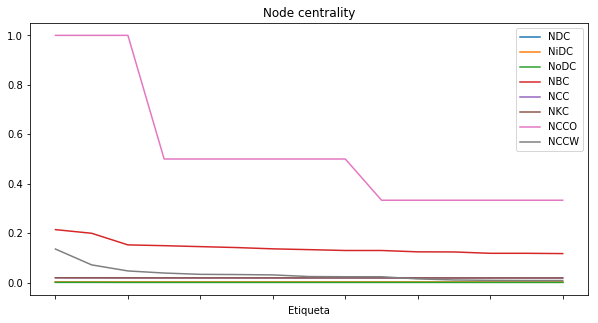

In [41]:
# Data reduction
#fnodes = nodes[hp["plot_node_metrics"]]
fnodes = nodes[['NDC','NiDC','NoDC','NBC','NCC','NKC','NCCO','NCCW']]
fnodes = fnodes.apply(lambda x: x.sort_values(ascending=False).values)
fig, ax = subplots()
fnodes[0:15].plot(ax=ax, title="Node centrality & Node Clustering", figsize=(10,5))
#ax.legend(["AAA", "BBB"]);

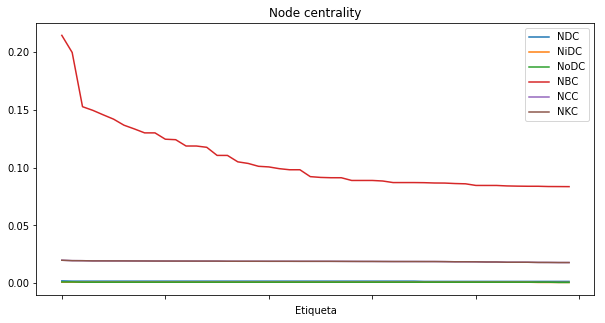

In [29]:
# Data reduction
#fnodes = nodes[hp["plot_node_metrics"]]
fnodes = nodes[['NDC','NiDC','NoDC']]
fnodes = fnodes.apply(lambda x: x.sort_values(ascending=False).values)
fig, ax = subplots()
fnodes[0:50].plot(ax=ax, title="Node centrality", figsize=(10,5))
#ax.legend(["AAA", "BBB"]);

In [ ]:
# Data reduction
#fnodes = nodes[hp["plot_node_metrics"]]
fnodes = nodes[['NDC','NBC','NCC']]
fnodes = fnodes.apply(lambda x: x.sort_values(ascending=False).values)
fig, ax = subplots()
fnodes[0:50].plot(ax=ax, title="Node centrality", figsize=(10,5))
#ax.legend(["AAA", "BBB"]);

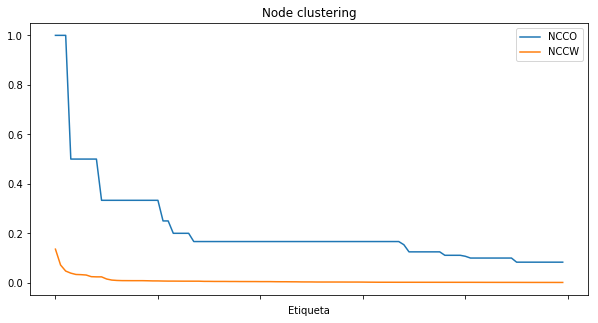

In [36]:
# Clustering Coefficients
cnodes = nodes[['NCCO','NCCW']]
cnodes = cnodes.apply(lambda x: x.sort_values(ascending=False).values)
cnodes[:100].plot( title="Node clustering", figsize=(10,5))

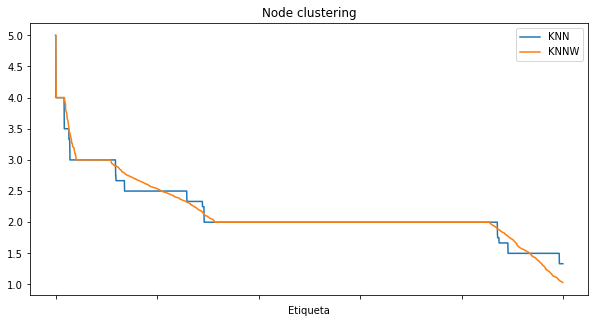

In [38]:
# nearest-neighbors degree
cnodes = nodes[['KNN','KNNW']]
cnodes = cnodes.apply(lambda x: x.sort_values(ascending=False).values)
cnodes[:300].plot( title="Node clustering", figsize=(10,5))

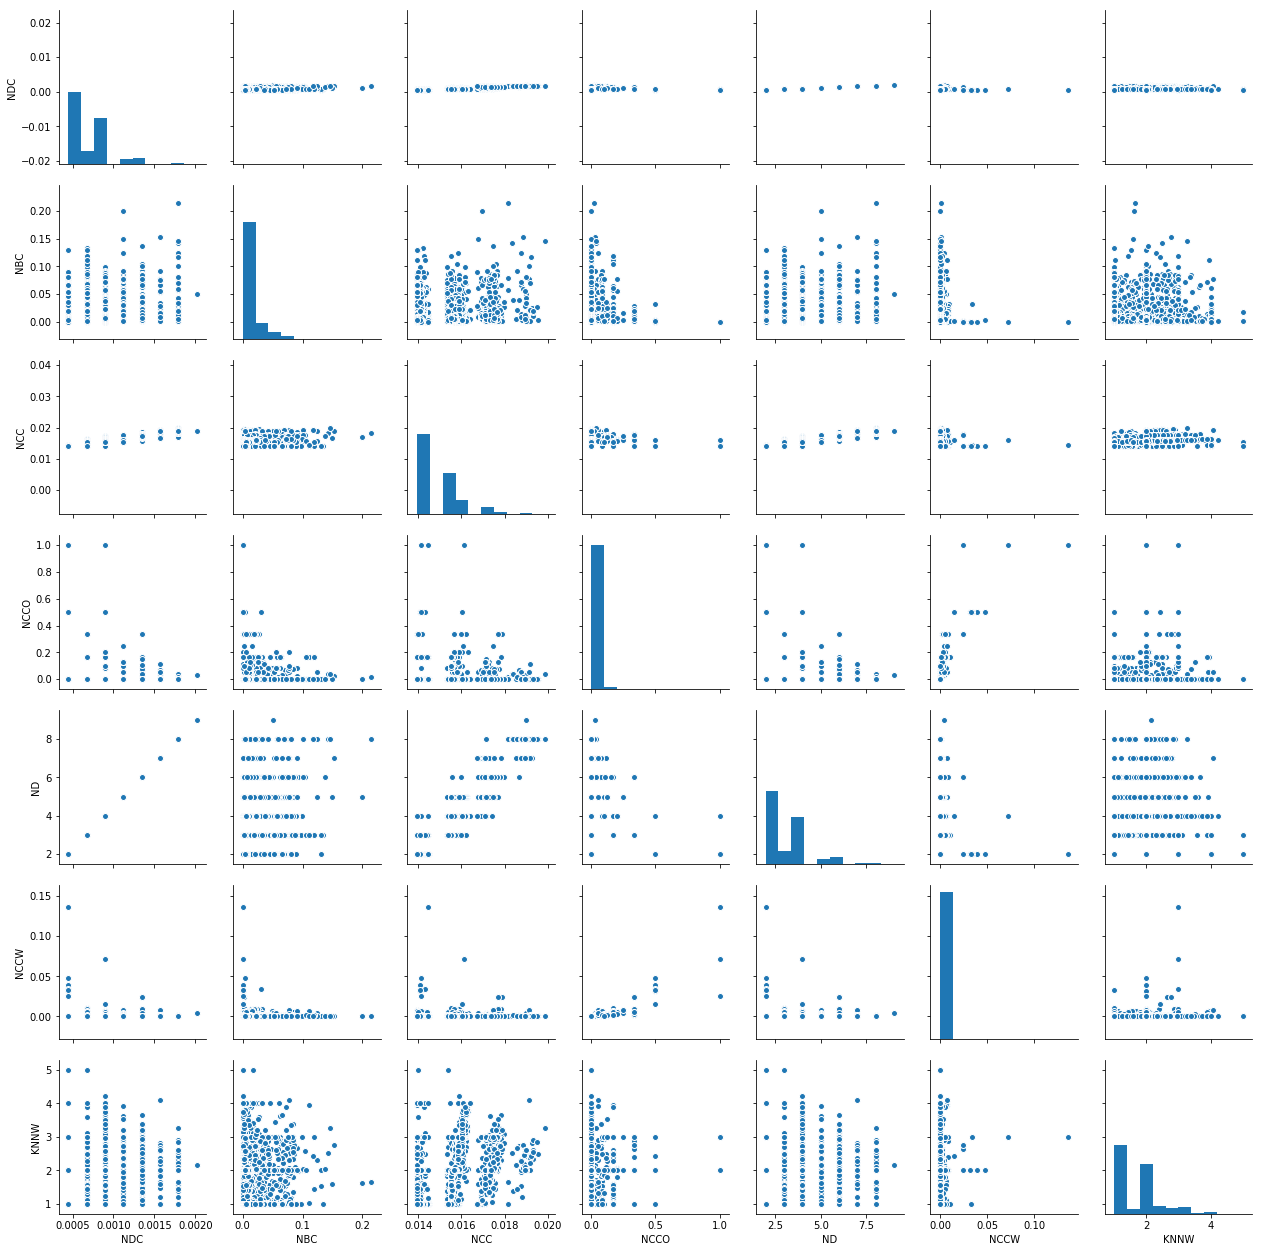

In [42]:
rnodes = nodes[['NDC','NBC','NCC','NCCO','ND','NCCW','KNNW']]
#rnodes = nodes[['NiDC','NoDC','NBC','NCC','NKC','NCCO','NCCW','KNNW']]
sns.pairplot(rnodes)

#### <a name="TVM_VZ">6.3 <span style="color:blue">Dimensionality reduction.</span></a>

We analyze node similarity/disimilarity by applying T-SNE, a dimensionality reduction tecnique that maintains geometrical properties.

In [6]:
# nodes = nodes[hp["plot_node_metrics"]]
nodes = nodes[['ND','NDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNNW']]

In [7]:
num_dimensions = 2

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=10, perplexity=30)
vectors = tsne.fit_transform(nodes)

In [8]:
labels = nodes.index.tolist()

In [9]:
x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]
#z_vals = [v[2] for v in vectors]

# Create a trace
trace = go.Scatter(
    x=x_vals,
    y=y_vals,
   # z=z_vals,
    mode='text',
    text=labels
    )

data = [trace]
init_notebook_mode(connected=True)
iplot(data, filename='word-embedding-plot')

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/tijuana_nodes_p10.png" width="200" height="40" alt="Perplexity 5"><span style="color:blue">Perplexity 10</span></center></th>
    <th class="tg-0pky"><center><img src="img/tijuana_nodes_p30.png" width="200" height="40" alt="Perplexity 30"><span style="color:blue">Perplexity 30</span></center></th>
    <th class="tg-0pky"><center><img src="img/tijuana_nodes_p50.png"width="200" height="40" alt="Perplexity 50"><span style="color:blue">Perplexity 50</span></center></th>
  </tr>
</table>

Perpexity defines how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. Tipical values are in the range of 5 to 50. Perplexity for the later image was 30. For clusters with perperxity 30 and 50 the clusters look equidistant. Cluster points are contained. Glpabl conectivity decrease as perperxity values increase.

In [21]:
# Store TSNE vectors to persistance
pvectors = pd.DataFrame(vectors)
pvectors.to_csv(hp["persistance"]["node_tsne"], index=True,  encoding="ISO-8859-1")

#### <a name="TVM_VZ">6.4 <span style="color:blue">Node clustering with HDBSCAN.</span></a>

For location extraction.

In [45]:
# Load TSNE vectors from persistance
vectors = pd.read_csv(hp["persistance"]["node_tsne"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')
vectors = vectors.values       # DataFrame to numpy

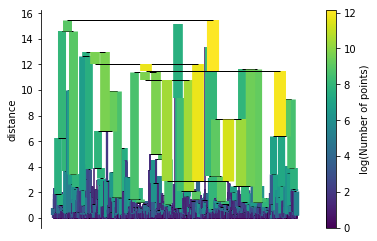

In [46]:
clusterer = hdbscan.RobustSingleLinkage(cut=0.125, k=8)
cluster_labels = clusterer.fit_predict(vectors)
hierarchy = clusterer.cluster_hierarchy_
alt_labels = hierarchy.get_clusters(0.100, 22)
hierarchy.plot()

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/cluster_nodes_2D_k2.png" width="300" height="50" alt="Perplexity 5"><span style="color:blue">2D nodes k2</span></center></th>
    <th class="tg-0pky"><center><img src="img/cluster_nodes_2D_k4.png" width="300" height="50" alt="Perplexity 30"><span style="color:blue">2D nodes k4</span></center></th>
    <th class="tg-0pky"><center><img src="img/cluster_nodes_2D_k8.png"width="300" height="50" alt="Perplexity 50"><span style="color:blue">2D nodes k8</span></center></th>
  </tr>
</table>


Ahora, es necesario identificar que vertices pertenecen a que grupo. Después, que trayectoria pertenece en almenos un umbral a una agrupacion. Las trayectorias resultantes, seran agregadas a una matriz por grupo. Esta sera visualizada aplicando los otros métodos de visualizacion.

In [47]:
pdf = pd.DataFrame(columns=['Label', 'Cluster','Size'])
for label in np.unique(cluster_labels):
    cluster = np.where(cluster_labels == label)
    pdf = pdf.append({'Label' : label , 'Cluster' : cluster[0],
                       'Size' : len(cluster[0])} , ignore_index=True)

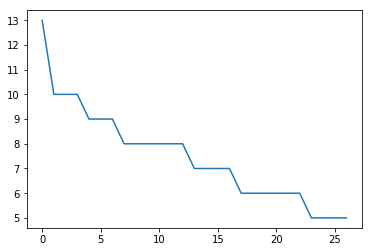

In [48]:
pdk = pdf.sort_values(by=['Size'],ascending=False)
plt.plot(pdk.Size[1:].values)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/node_clusters_sim_2D_k2.png" width="300" height="50" alt="Perplexity 5"><span style="color:blue">2D nodes k2</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_clusters_sim_2D_k4.png" width="300" height="50" alt="Perplexity 30"><span style="color:blue">2D nodes k4</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_clusters_sim_2D_k8.png"width="300" height="50" alt="Perplexity 50"><span style="color:blue">2D nodes k8</span></center></th>
  </tr>
</table>

In [15]:
# Store clusters to persistance
pdk.to_csv(hp["persistance"]["node_clusters"], index=True,  encoding="ISO-8859-1")

NameError: name 'pdk' is not defined

In [52]:
# Loas clusters from persistance
clusters = pd.read_csv(hp["persistance"]["node_clusters"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')

#### <a name="TVM_VZ">6.5 <span style="color:blue">Point extraction and visualization</span></a>

In [15]:
helper = TVM_Helper()

In [16]:
mti = {    # Metric intervals
    "ND"   : (8.9,9.1),  
    "NDC"  : (0.00200, 0.00202),
    "NiDC" : (0.00088, 0.000896860986547085), 
    "NoDC" : (0.00111, 0.00112107623318385), 
    "NBC"  : (0.141969192572649, 0.214479674382964),
    "NCC"  : (0.0189, 0.019),
    "NLRC" : (),
    "NKC"  : (),
    "NCCO" : (0.9, 1),
    "NCCW" : (0.0109464205162627,  0.135891651911769),
    "KNN"  : (4.9, 5),
    "KNNW" : (4.9, 5)
}
    

In [17]:
#Save intervals firt range
locations_ND = helper.locations( mti["ND"][0], mti["ND"][1], nodes,"ND")
locations_NDC = helper.locations( mti["NDC"][0], mti["NDC"][1], nodes,"NDC")
locations_NBC = helper.locations( mti["NBC"][0], mti["NBC"][1], nodes,"NBC")
locations_NCC = helper.locations( mti["NCC"][0], mti["NCC"][1], nodes,"NCC")
locations_NCCO = helper.locations( mti["NCCO"][0], mti["NCCO"][1], nodes,"NCCO")
locations_NCCW = helper.locations( mti["NCCW"][0], mti["NCCW"][1], nodes,"NCCW")
locations_KNN = helper.locations( mti["KNN"][0], mti["KNN"][1], nodes,"KNN")
locations_KNNW = helper.locations( mti["KNNW"][0], mti["KNNW"][1], nodes,"KNNW")

In [18]:
mti_2range = {    # Metric intervals
    "ND"   : (7.9,8.1), 
    "NDC"  : (0.001792, 0.001794),
    "NiDC" : (0.000670, 0.000672645739910313), 
    "NoDC" : (0.00089680, 0.000896860986547085), 
    "NBC"  : (0.0912704855097807, 0.136756578677557), 
    "NCC"  : (0.0179, 0.0181),
    "NLRC" : (),
    "NKC"  : (),
    "NCCO" : (0.49, 0.6),
    "NCCW" : (0.00501503288895558, 0.00945026660054347),
    "KNN"  : (3.9, 4.1),
    "KNNW" : (4, 4.25)
}


In [19]:
#Save intervals second range
locations_ND2 = helper.locations( mti_2range["ND"][0], mti_2range["ND"][1], nodes,"ND")
locations_NDC2 = helper.locations( mti_2range["NDC"][0], mti_2range["NDC"][1], nodes,"NDC")
locations_NBC2 = helper.locations( mti_2range["NBC"][0], mti_2range["NBC"][1], nodes,"NBC")
locations_NCC2 = helper.locations( mti_2range["NCC"][0], mti_2range["NCC"][1], nodes,"NCC")
locations_NCCO2 = helper.locations( mti_2range["NCCO"][0], mti_2range["NCCO"][1], nodes,"NCCO")
locations_NCCW2 = helper.locations( mti_2range["NCCW"][0], mti_2range["NCCW"][1], nodes,"NCCW")
locations_KNN2 = helper.locations( mti_2range["KNN"][0], mti_2range["KNN"][1], nodes,"KNN")
locations_KNNW2 = helper.locations( mti_2range["KNNW"][0],mti_2range["KNNW"][1], nodes,"KNNW")

In [20]:
mti_3range = {    # Metric intervals
    "ND"   : (6.9,7.1),
    "NDC"  : (0.001569500, 0.00156950672645739),
    "NiDC" : (),
    "NoDC" : (0.000670, 0.000672645739910313), 
    "NBC"  : (0.0889195, 0.0889199019370223),
    "NCC"  : (0.0178501442898309, 0.0179947995684242),
    "NLRC" : (),
    "NKC"  : (), 
    "NCCO" : (0.32, 0.333333333333333),
    "NCCW" : (0.0042091280599286, 0.00493784684925252),
    "KNN"  : (3.4, 3.5),
    "KNNW" : (3.525505494276, 3.95561722940555)
}

In [21]:
#Save intervals 3er range
locations_ND3 = helper.locations( mti_3range["ND"][0], mti_3range["ND"][1], nodes,"ND")
locations_NDC3 = helper.locations( mti_3range["NDC"][0], mti_3range["NDC"][1], nodes,"NDC")
locations_NBC3 = helper.locations( mti_3range["NBC"][0], mti_3range["NBC"][1], nodes,"NBC")
locations_NCC3 = helper.locations( mti_3range["NCC"][0], mti_3range["NCC"][1], nodes,"NCC")
locations_NCCO3 = helper.locations( mti_3range["NCCO"][0], mti_3range["NCCO"][1], nodes,"NCCO")
locations_NCCW3 = helper.locations( mti_3range["NCCW"][0], mti_3range["NCCW"][1], nodes,"NCCW")
locations_KNN3 = helper.locations( mti_3range["KNN"][0], mti_3range["KNN"][1], nodes,"KNN")
locations_KNNW3 = helper.locations( mti_3range["KNNW"][0],mti_3range["KNNW"][1], nodes,"KNNW")

Note: Convert file .geojson to shapefile .shp, to be accepted the polygons like another layer in basemap.

File converted by https://mygeodata.cloud/converter/geojson-to-shp

Basemap basic functions by https://basemaptutorial.readthedocs.io/en/latest/index.html

Creating High-Resolution Maps Using arcgisimage in Python:
https://www.bdmweather.com/2018/04/python-m-arcgisimage-basemap-options/

Background methods, arcgisimage from:
https://basemaptutorial.readthedocs.io/en/latest/backgrounds.html


Comparing possible solutions for mapping in Python:
https://github.com/ispmarin/maps like Folium, Plotly, Basemap and Cartopy


Matplotlib recognizes the following formats to specify a color:
   1. An RGB or RGBA tuple of float values in [0, 1] (e.g., (0.1, 0.2, 0.5) or (0.1, 0.2, 0.5, 0.3));
   2. A hex RGB or RGBA string (e.g., '#0f0f0f' or '#0f0f0f80'; case-insensitive);
   3. A string representation of a float value in [0, 1] inclusive for gray level (e.g., '0.5');
   4. One of {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};
   5. One of the Tableau Colors from the 'T10' categorical palette (the default color cycle):            6. {'tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',   'tab:gray', 'tab:olive', 'tab:cyan'} (case-insensitive); See https://matplotlib.org/api/colors_api.html

Matplotlib markers:

marker= '.', '*', 'D', '+', 'x', '1' ... see https://matplotlib.org/api/markers_api.html

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning:


The dedent function was deprecated in M

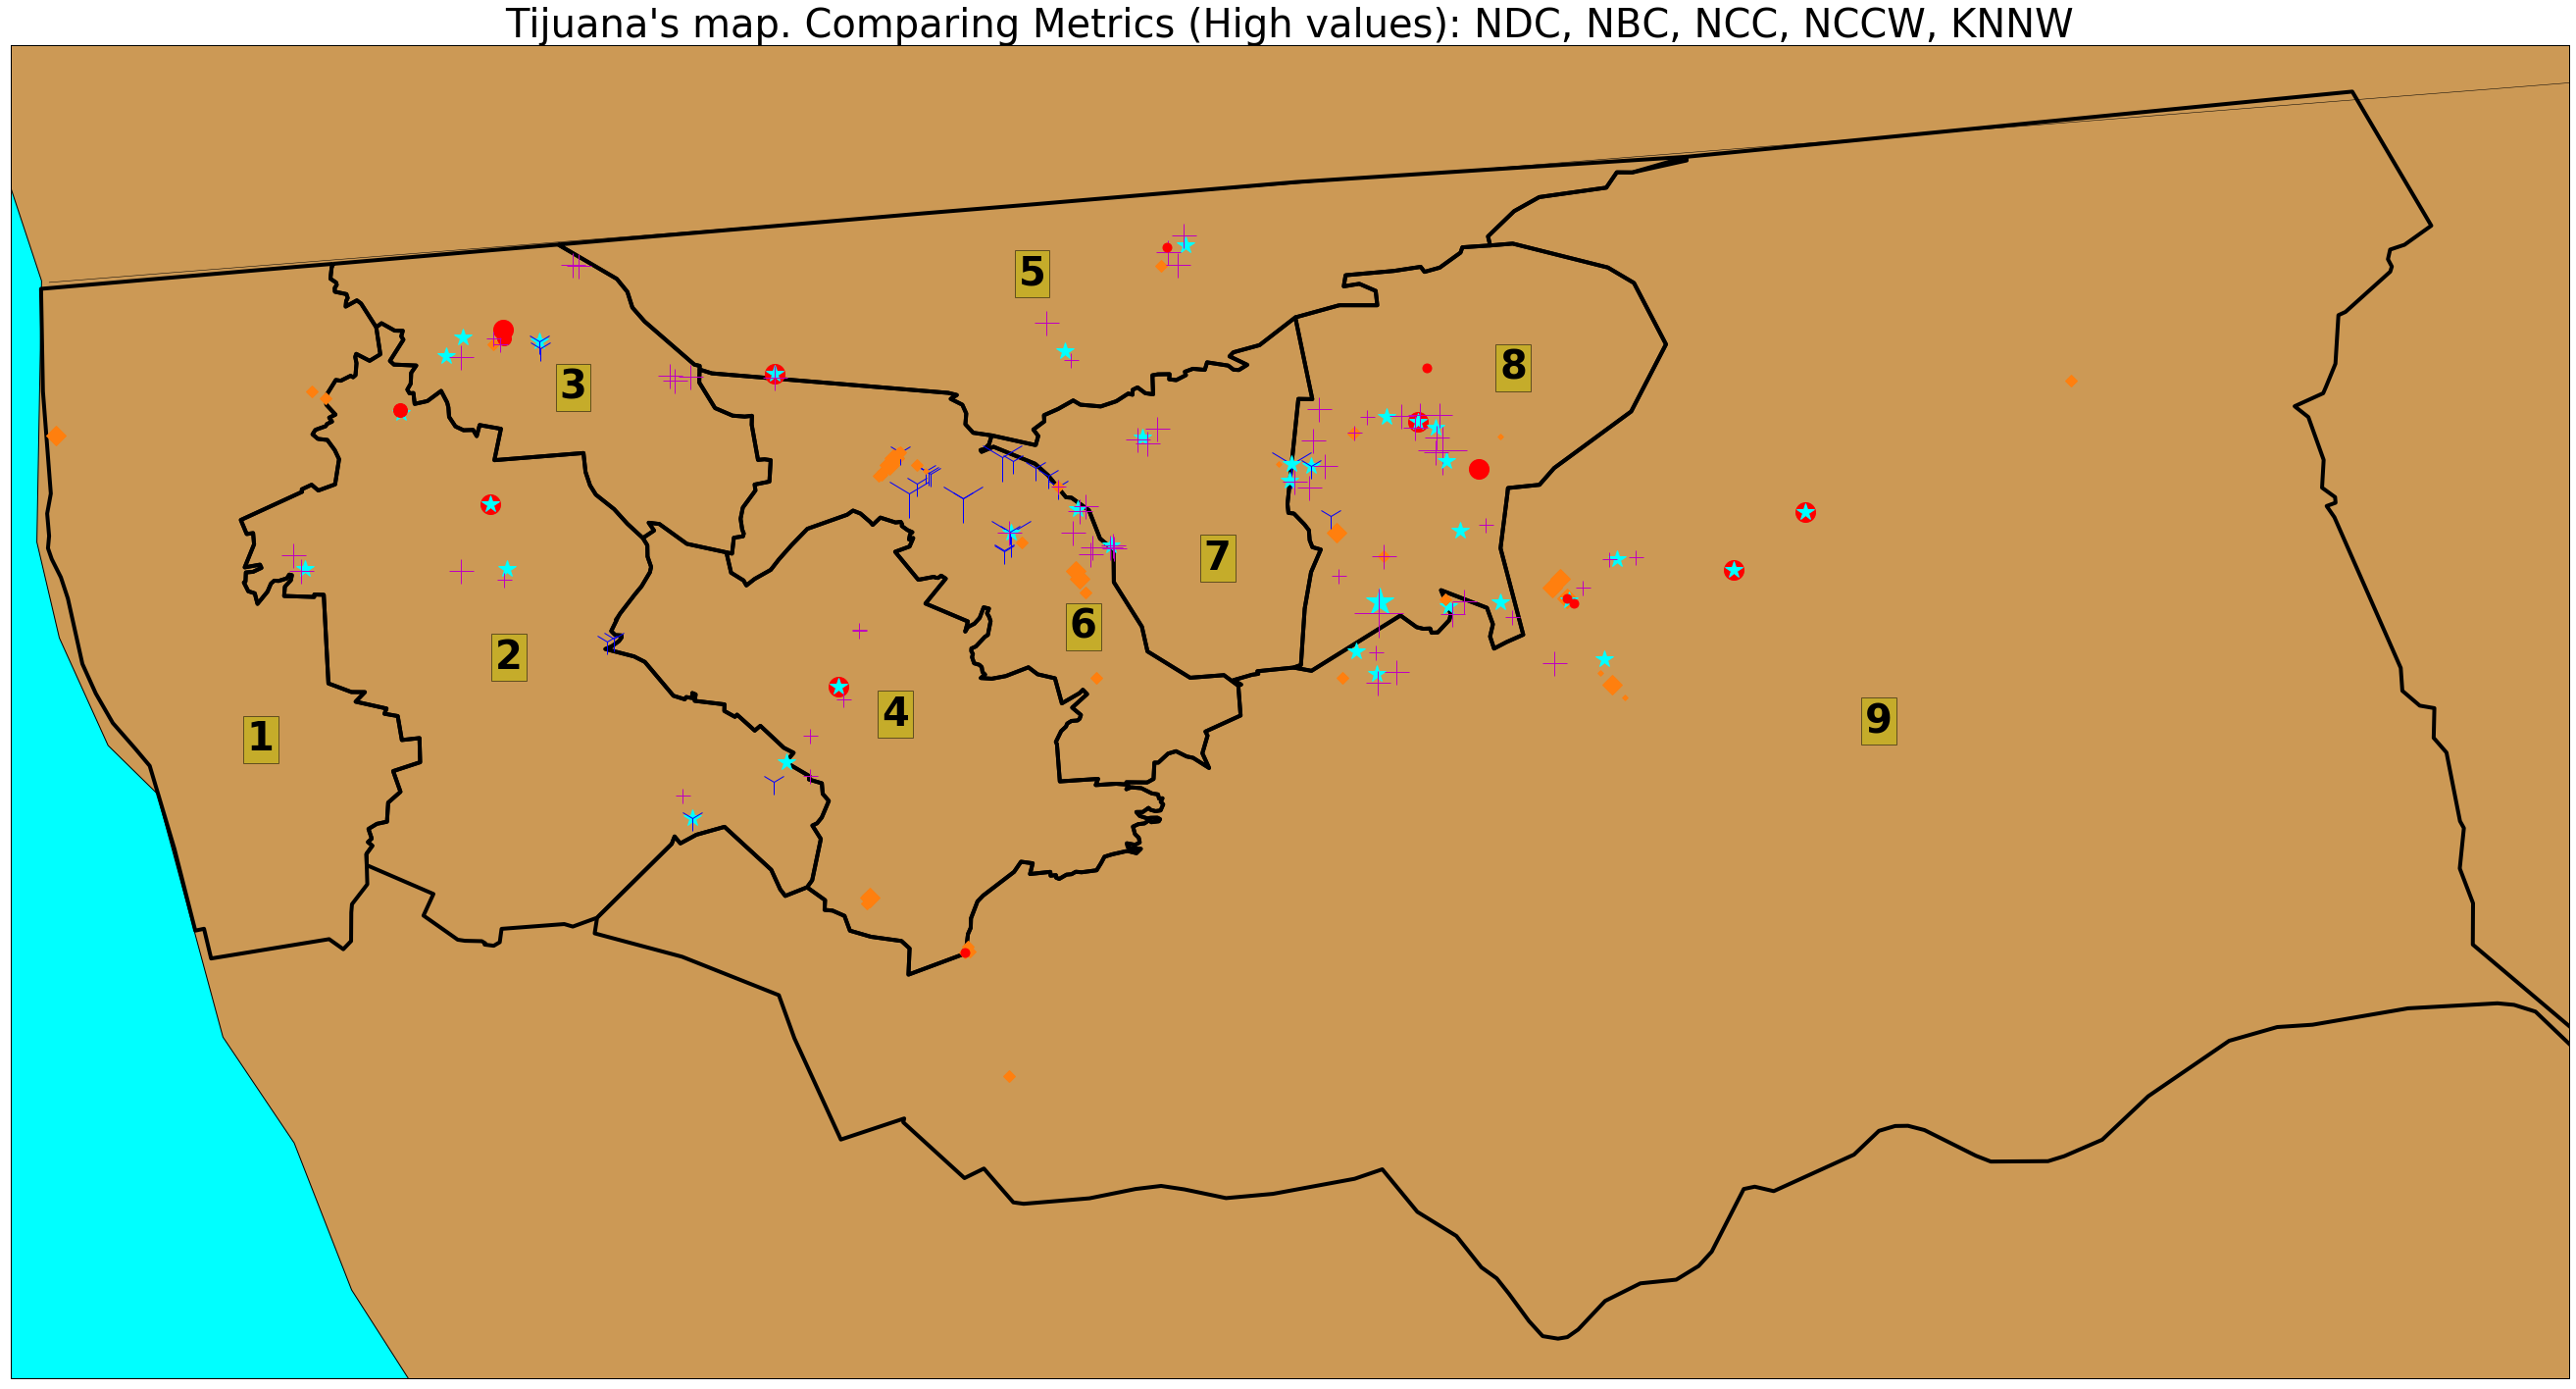

In [43]:
plt.figure(figsize=(50,25))

plt.title("Map 1. Tijuana's map. Comparing Metrics (High values): NDC, NBC, NCC, NCCW, KNNW", fontsize=40)

#area delimitada del map.
map = Basemap(llcrnrlon=-117.13,llcrnrlat=32.33, urcrnrlon=-116.65,urcrnrlat=32.58,resolution = 'h')
#map = Basemap(llcrnrlon=-117.13,llcrnrlat=32.36, urcrnrlon=-116.65,urcrnrlat=32.58,resolution = 'h')

#atributos de mapa
map.drawcoastlines()
map.drawcountries()
map.drawstates()
#map.drawmapboundary(fill_color='aqua') #solid water background
#map.fillcontinents(color='#cc9955') #solid background
#choose colors {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};



# Import maps by service = 'type_of_service', example "ESRI_Imagery_World_2D", "ESRI_StreetMap_World_2D", 
# "NatGeo_World_Map", "World_Street_Map", etc... from # https://www.bdmweather.com/2018/04/python-m-arcgisimage-basemap-options/
map.arcgisimage(service='World_Street_Map', xpixels = 2000, verbose= False)
plt.savefig('World_Street_Map', bbox_inches = "tight", dpi = 500) 


#import polygons: 9 "districs"
import_region =map.readshapefile(r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\Delegaciones-polygon", "Delegaciones-polygon", color='k',linewidth=4)


#texto en mapa
lat, lon= 32.4499029,-117.085669
x, y=map(lon,lat)
plt.text(x,y,'1',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 
            # bbox=dict(facecolor='tab:pink', alpha=0.2) alpha es intensidad del color
                                                                            
lat, lon= 32.4652866, -117.0390299
x, y=map(lon,lat)
plt.text(x,y,'2',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.5158687,-117.0269895  
x, y=map(lon,lat)
plt.text(x,y,'3',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4545541, -116.9665274
x, y=map(lon,lat)
plt.text(x,y,'4',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.53719, -116.9409228
x, y=map(lon,lat)
plt.text(x,y,'5',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4709812, -116.9312751
x, y=map(lon,lat)
plt.text(x,y,'6',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4838571, -116.9060911
x, y=map(lon,lat)
plt.text(x,y,'7',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.5195782, -116.850626
x, y=map(lon,lat)
plt.text(x,y,'8',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4532737, -116.7820789
x, y=map(lon,lat)
plt.text(x,y,'9',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))



# Solo para agregar los puntos de manera iterativa
for t in locations_NDC:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=32,color='aqua')
    
for t in locations_NBC:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='1', markersize=55,color='b')

for t in locations_NCC:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='.', markersize=45,color='r')
    
for t in locations_NCCW:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='D', markersize=17,color='tab:orange')
    
for t in locations_KNNW:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='+', markersize=55,color='m')
    
#second range****************************************************   

for t in locations_NDC2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=18,color='aqua')
    
for t in locations_NBC2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='1', markersize=25,color='b')

for t in locations_NCC2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='.', markersize=28,color='r')
    
for t in locations_NCCW2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='D', markersize=8,color='tab:orange')
    
for t in locations_KNNW2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='+', markersize=25,color='m')

#third range****************************************************   

for t in locations_NDC3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=12,color='aqua')
    
for t in locations_NBC3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='1', markersize=18,color='b')

for t in locations_NCC3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='.', markersize=18,color='r')
    
for t in locations_NCCW3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='D', markersize=4,color='tab:orange')
    
for t in locations_KNNW3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='+', markersize=15,color='m')
    



plt.show()
plt.savefig('Map-NDC-NBC-NCC-NCCW-KNNW.png')

Map. 1. Comparing Metrics (High values): NDC, NBC, NCC, NCCW, KNNW
A total of 104 routes were were analyzed through the language Python version 3.7.2 [27] with NetworkX python library [25].

Findings of all metrics on the map

In the interaction of the metrics, it observes that there is a greater intersection of roads over the regions 6, 8 and 3.

The highest values of the metric NDC are in many regions around the city, mainly in region 8 around the districts Villa Fontana, El Florido, Buenos Aires Sur and others, where the crucial locations within the network are identified, due to the quantity of roads that converge there.

These findings show the highest values of the metric NBC are in region 6 and 8, these locations have great influence within the network due to their concentration of routes, so blocking these roads causes chaos within the current network over Blvd. Gustavo Diaz Ordaz, Blvd. Federico Benitez, Blvd. Insurgentes, Avenida Fco. Javier Mina and others.

Talking about the metric NCC its highest values are over many regions too, highlighting Villa Fontana, Zona Centro, Buena Vista, Obrera, Sanchez Taboada and others.

About the metric NCCW, the highest values are over the regions 6, 9 and 4, this clusters are located over Blvd. Lazaro Cardenas, Blvd. Paseo del Rio, San Francisco II section, Fraccionamiento el Refugio.

Respect to the metric KNNW its highest values are over many regions, highlighting Villa Fontana, El Florido, around "Macro Plaza area", Blvd. Rodolfo Sanchez Taboada and Prolongacion Paseo de los Heroes, around Avenida Frontera, around Blvd. Limon Padilla, and others.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning:


The dedent function was deprecated in M

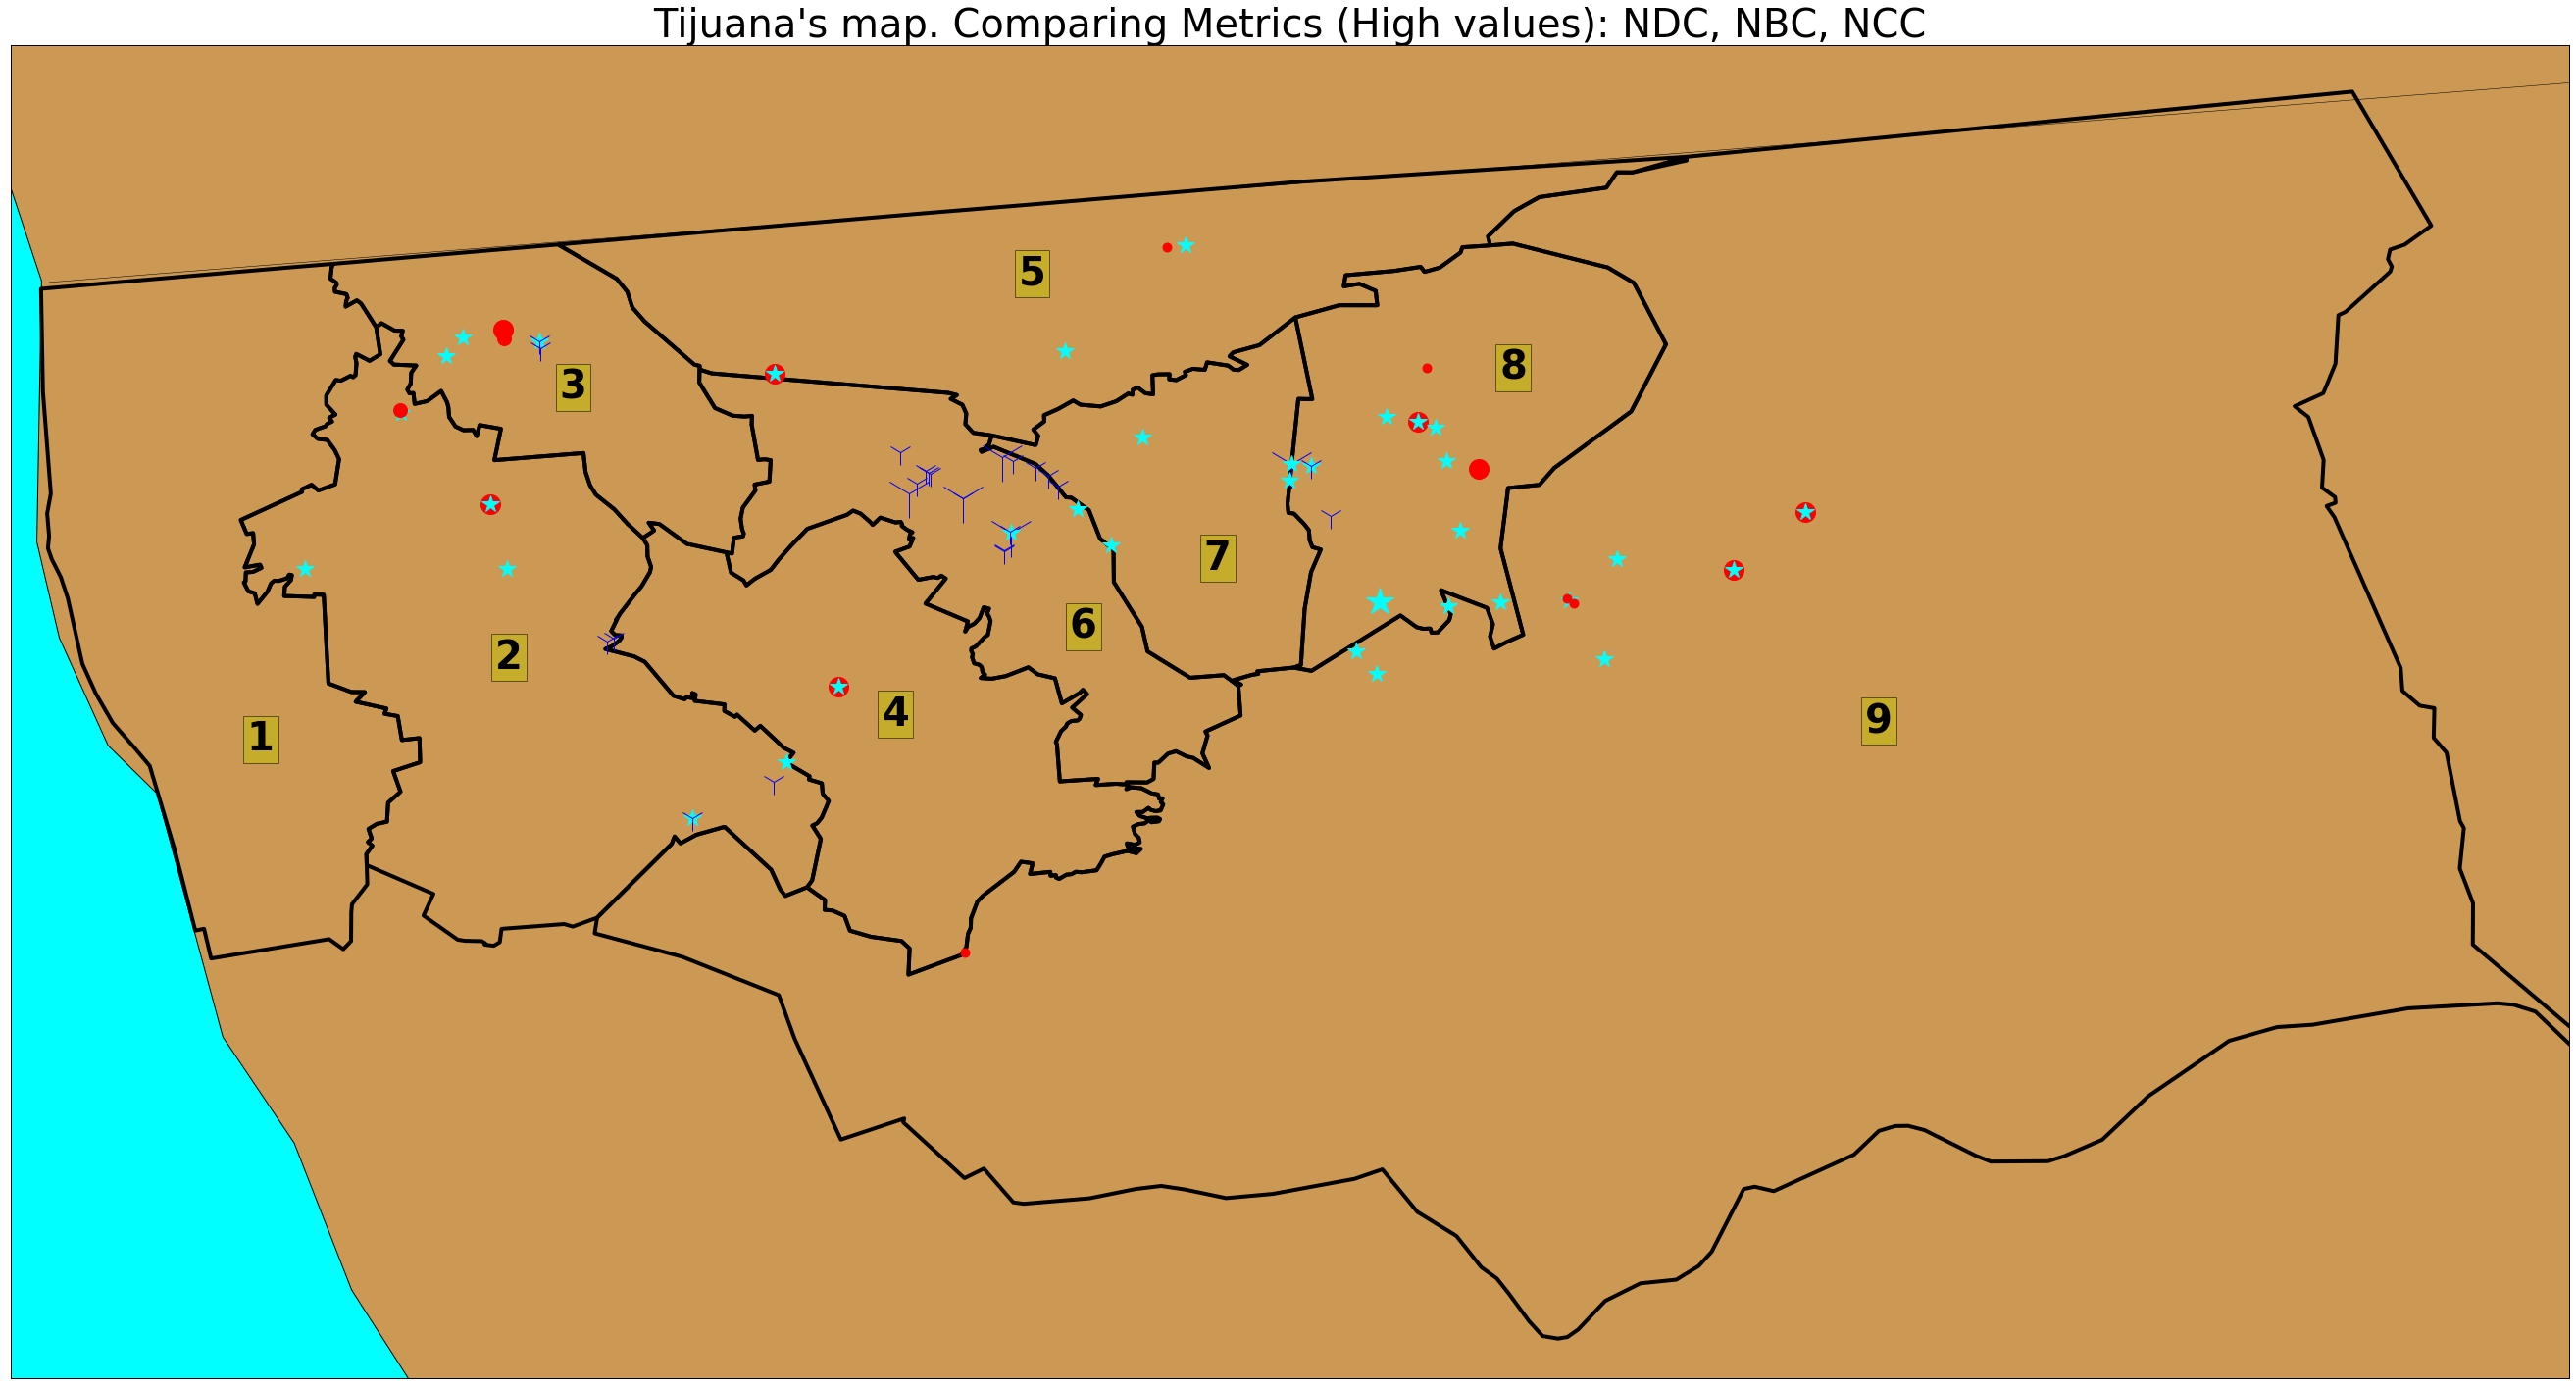

In [39]:
plt.figure(figsize=(50,25))

plt.title("Map 2. Tijuana's map. Comparing Metrics (High values): NDC, NBC, NCC", fontsize=40)

#area delimitada del map.
map = Basemap(llcrnrlon=-117.13,llcrnrlat=32.33, urcrnrlon=-116.65,urcrnrlat=32.58,resolution = 'h')


#atributos de mapa
map.drawcoastlines()
map.drawcountries()
map.drawstates()
#map.drawmapboundary(fill_color='aqua') #solid water background
#map.fillcontinents(color='#cc9955') #solid background
#choose colors {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};



# Import maps by service = 'type_of_service', example "ESRI_Imagery_World_2D", "ESRI_StreetMap_World_2D", 
# "NatGeo_World_Map", "World_Street_Map", etc... from # https://www.bdmweather.com/2018/04/python-m-arcgisimage-basemap-options/
map.arcgisimage(service='World_Street_Map', xpixels = 2000, verbose= False)
plt.savefig('World_Street_Map', bbox_inches = "tight", dpi = 500) 


#import polygons: 9 "districs"
import_region =map.readshapefile(r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\Delegaciones-polygon", "Delegaciones-polygon", color='k',linewidth=4)


#texto en mapa
lat, lon= 32.4499029,-117.085669
x, y=map(lon,lat)
plt.text(x,y,'1',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 
            # bbox=dict(facecolor='tab:pink', alpha=0.2) alpha es intensidad del color
                                                                            
lat, lon= 32.4652866, -117.0390299
x, y=map(lon,lat)
plt.text(x,y,'2',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.5158687,-117.0269895  
x, y=map(lon,lat)
plt.text(x,y,'3',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4545541, -116.9665274
x, y=map(lon,lat)
plt.text(x,y,'4',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.53719, -116.9409228
x, y=map(lon,lat)
plt.text(x,y,'5',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4709812, -116.9312751
x, y=map(lon,lat)
plt.text(x,y,'6',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4838571, -116.9060911
x, y=map(lon,lat)
plt.text(x,y,'7',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.5195782, -116.850626
x, y=map(lon,lat)
plt.text(x,y,'8',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4532737, -116.7820789
x, y=map(lon,lat)
plt.text(x,y,'9',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 




# Solo para agregar los puntos de manera iterativa
for t in locations_NDC:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=32,color='aqua')
    
for t in locations_NBC:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='1', markersize=55,color='b')

for t in locations_NCC:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='.', markersize=45,color='r')
    


#second range****************************************************   

for t in locations_NDC2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=18,color='aqua')
    
for t in locations_NBC2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='1', markersize=25,color='b')

for t in locations_NCC2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='.', markersize=28,color='r')
    

#third range****************************************************   

for t in locations_NDC3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=12,color='aqua')
    
for t in locations_NBC3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='1', markersize=18,color='b')

for t in locations_NCC3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='.', markersize=18,color='r')

plt.show()
plt.savefig('Map-NDC-NBC-NCC.png')

In [ ]:
plt.figure(figsize=(50,25))

plt.title("Map 3.Tijuana's map. Comparing all values: NDC", fontsize=40)

#area delimitada del map.
map = Basemap(llcrnrlon=-117.13,llcrnrlat=32.33, urcrnrlon=-116.65,urcrnrlat=32.58,resolution = 'h')


#atributos de mapa
map.drawcoastlines()
map.drawcountries()
map.drawstates()
#map.drawmapboundary(fill_color='aqua') #solid water background
#map.fillcontinents(color='#cc9955') #solid background
#choose colors {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};



# Import maps by service = 'type_of_service', example "ESRI_Imagery_World_2D", "ESRI_StreetMap_World_2D", 
# "NatGeo_World_Map", "World_Street_Map", etc... from # https://www.bdmweather.com/2018/04/python-m-arcgisimage-basemap-options/
map.arcgisimage(service='World_Street_Map', xpixels = 2000, verbose= False)
plt.savefig('World_Street_Map', bbox_inches = "tight", dpi = 500) 


#import polygons: 9 "districs"
import_region =map.readshapefile(r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\Delegaciones-polygon", "Delegaciones-polygon", color='k',linewidth=4)


#texto en mapa
lat, lon= 32.4499029,-117.085669
x, y=map(lon,lat)
plt.text(x,y,'1',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 
            # bbox=dict(facecolor='tab:pink', alpha=0.2) alpha es intensidad del color
                                                                            
lat, lon= 32.4652866, -117.0390299
x, y=map(lon,lat)
plt.text(x,y,'2',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.5158687,-117.0269895  
x, y=map(lon,lat)
plt.text(x,y,'3',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4545541, -116.9665274
x, y=map(lon,lat)
plt.text(x,y,'4',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.53719, -116.9409228
x, y=map(lon,lat)
plt.text(x,y,'5',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4709812, -116.9312751
x, y=map(lon,lat)
plt.text(x,y,'6',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4838571, -116.9060911
x, y=map(lon,lat)
plt.text(x,y,'7',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.5195782, -116.850626
x, y=map(lon,lat)
plt.text(x,y,'8',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

lat, lon= 32.4532737, -116.7820789
x, y=map(lon,lat)
plt.text(x,y,'9',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 




# Solo para agregar los puntos de manera iterativa
for t in locations_NDC:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=29,color='aqua')
    

    
plt.show()
plt.savefig('Map-NDC.png')

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.

C:\Users\Belgica\Anaconda3\Lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning:


The dedent function was deprecated in M

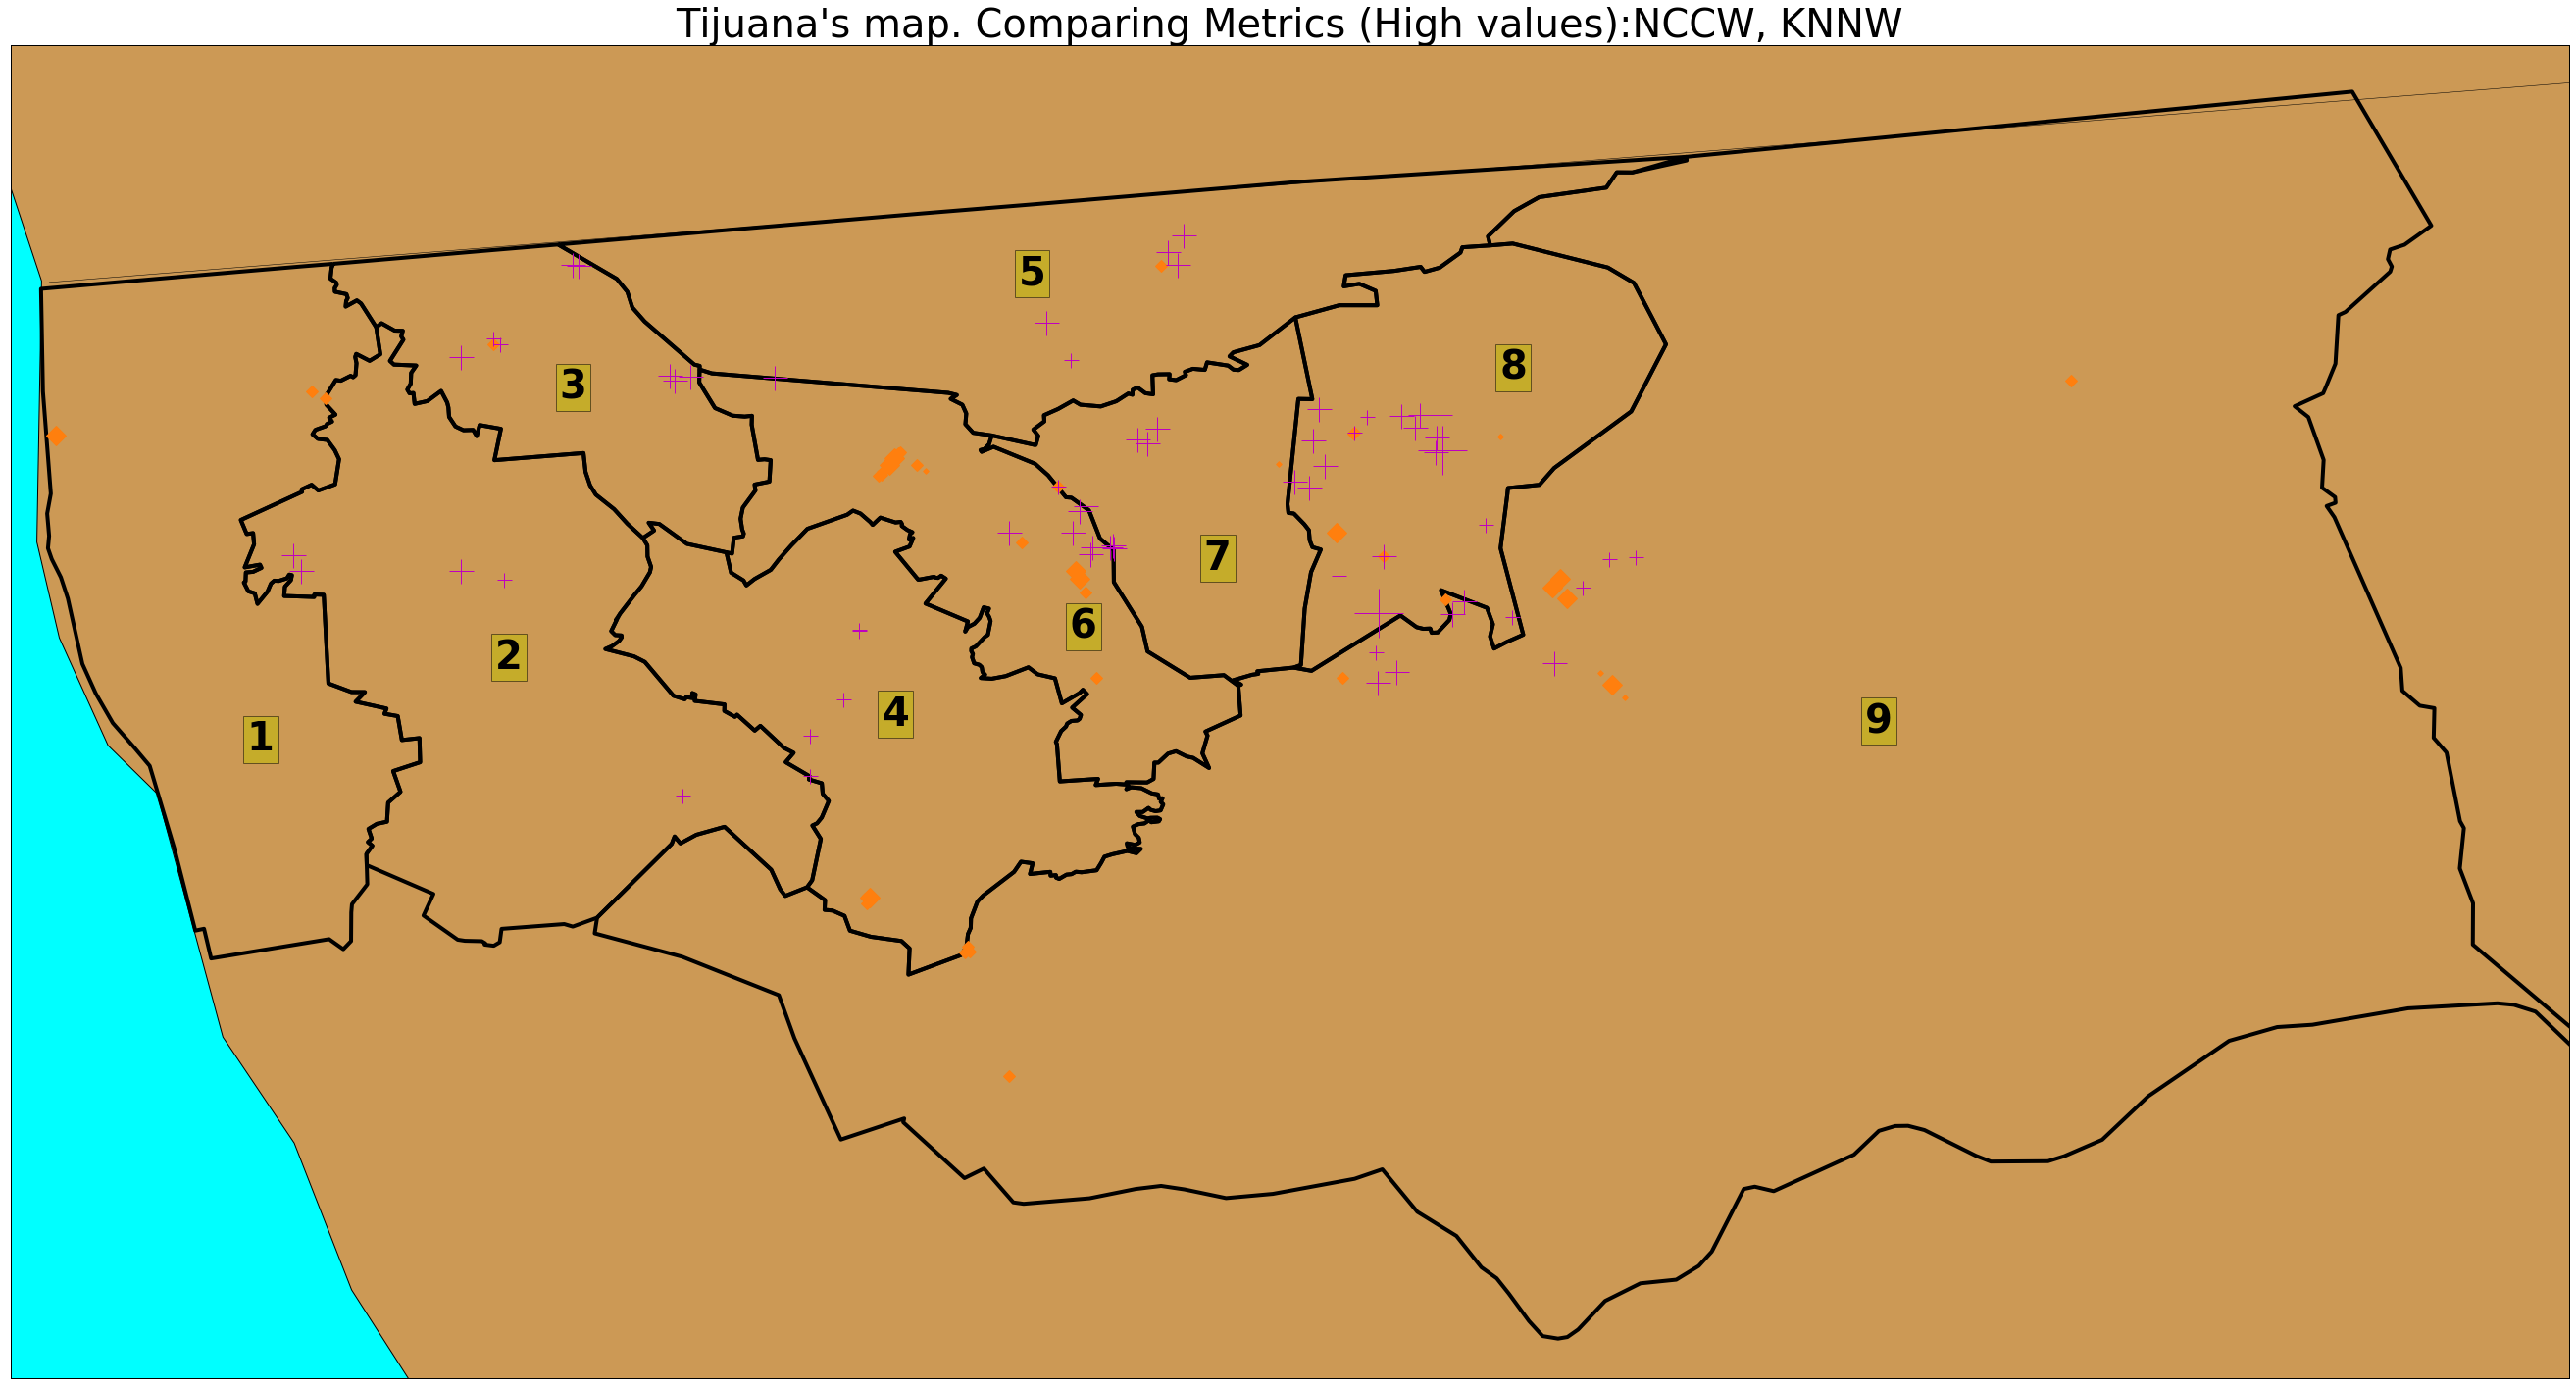

In [44]:
plt.figure(figsize=(50,25))

plt.title("Map 4.Tijuana's map. Comparing Metrics (High values):NCCW, KNNW", fontsize=40)

#area delimitada del map.
map = Basemap(llcrnrlon=-117.13,llcrnrlat=32.33, urcrnrlon=-116.65,urcrnrlat=32.58,resolution = 'h')

#atributos de mapa
map.drawcoastlines()
map.drawcountries()
map.drawstates()
#map.drawmapboundary(fill_color='aqua') #solid water background
#map.fillcontinents(color='#cc9955') #solid background
#choose colors {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'};



# Import maps by service = 'type_of_service', example "ESRI_Imagery_World_2D", "ESRI_StreetMap_World_2D", 
# "NatGeo_World_Map", "World_Street_Map", etc... from # https://www.bdmweather.com/2018/04/python-m-arcgisimage-basemap-options/
map.arcgisimage(service='World_Street_Map', xpixels = 2000, verbose= False)
plt.savefig('World_Street_Map', bbox_inches = "tight", dpi = 500) 


#import polygons: 9 "districs"
import_region =map.readshapefile(r"C:\Users\Belgica\Documents\GitHub\TVM_Tj\data\Delegaciones-polygon", "Delegaciones-polygon", color='k',linewidth=4)


#texto en mapa
lat, lon= 32.4499029,-117.085669
x, y=map(lon,lat)
plt.text(x,y,'1',fontsize=40,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 
            # bbox=dict(facecolor='tab:pink', alpha=0.2) alpha es intensidad del color
                                                                            
lat, lon= 32.4652866, -117.0390299
x, y=map(lon,lat)
plt.text(x,y,'2',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.5158687,-117.0269895  
x, y=map(lon,lat)
plt.text(x,y,'3',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4545541, -116.9665274
x, y=map(lon,lat)
plt.text(x,y,'4',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.53719, -116.9409228
x, y=map(lon,lat)
plt.text(x,y,'5',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4709812, -116.9312751
x, y=map(lon,lat)
plt.text(x,y,'6',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4838571, -116.9060911
x, y=map(lon,lat)
plt.text(x,y,'7',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.5195782, -116.850626
x, y=map(lon,lat)
plt.text(x,y,'8',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))

lat, lon= 32.4532737, -116.7820789
x, y=map(lon,lat)
plt.text(x,y,'9',fontsize=40,fontweight='bold', ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5))




# Solo para agregar los puntos de manera iterativa
    
for t in locations_NCCW:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='D', markersize=17,color='tab:orange')
    
for t in locations_KNNW:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='+', markersize=55,color='m')
    
#second range****************************************************   
 
for t in locations_NCCW2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='D', markersize=8,color='tab:orange')
    
for t in locations_KNNW2:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='+', markersize=25,color='m')

#third range****************************************************   


for t in locations_NCCW3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='D', markersize=4,color='tab:orange')
    
for t in locations_KNNW3:
    lat = float(t[0])
    lon=float(t[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='+', markersize=15,color='m')


plt.show()
plt.savefig('Map-NCCW-KNNW.png')

### <a name="TVM_LIB">8. <span style="color:blue">References</span></a>

1. Gil, J. Y. & Kimmel, R.Efficient dilation, erosion, opening, and closing algorithms IEEE Transactions on Pattern Analysis and Machine Intelligence, 2002 , 24 , 1606-1617
2. Jackway, P. T. & Deriche, M. Scale-space properties of the multiscale morphological dilation-erosion IEEE Transactions on Pattern Analysis and Machine Intelligence, 1996, 18, 38-51 
3. Lin, J. & Ban, Y. Comparative Analysis on Topological Structures of Urban Street Networks. ISPRS Int. J. Geo-Information, 2017 , 6 , 295
4. Lin, J. Spatial analysis and modeling of urban transportation networks KTH, Geoinformatics, KTH, Geoinformatics, 2017 , 77.
5. Barthélemy, M. Spatial networks. Physics Reports, Elsevier BV, 2011 , 499 , 1-101 
6. Newman, M. E. J. Networks: An Introduction. Oxford University Press, 2010
7. Rodrigue, J.-P. The Geography of Transport Systems. Routledge, 2013    
8. Cardozo, O. D.; Erica Leonor, G. & Miguel Alejandro, P. Teoría de grafos y sistemas de información geográfica aplicados al transporte público de pasajeros en resistencia (Argentina). Revista Transporte y Territorio, 2009 , 89-111 
9. Jiang, B. & Claramunt, C. Topological Analysis of Urban Street Networks. Environment and Planning B: Planning and Design, SAGE Publications, 2004 , 31 , 151-162
10. Scheurer, J.; Curtis, C. & Porta, S. Spatial network analysis of public transport systems : developing a strategic planning tool to assess the congruence of movement and urban structure in Australian cities Australasian Transport Research Forum, Australasian Transport Research Forum, 2007 
11. Sevtsuk, A. & Mekonnen, M. Urban network analysis. A new toolbox for ArcGIS. Revue internationale de géomatique, Lavoisier, 2012 , 22 , 287-305
12. Viana, M. P.; Strano, E.; Bordin, P. & Barthelemy, M. The simplicity of planar networks. Scientific Reports, Springer Science and Business Media LLC, 2013 , 3
13. Harris, J.; Hirst, J. L. & Mossinghoff, M. Combinatorics and Graph Theory. Springer New York, 2008
14. Kirkley, A.; Barbosa, H.; Barthelemy, M. & Ghoshal, G.From the betweenness centrality in street networks to structural invariants in random planar graphs. Nature Communications, Springer Nature, 2018 , 9
15. Kansky, K. & Danscoine, P. Measures of network structure. Flux, PERSEE Program, 1989 , 5 , 89-121
16. Porta, S.; Crucitti, P. & Latora, V. The Network Analysis of Urban Streets: A Primal Approach. Environment and Planning B: Planning and Design, SAGE Publications, 2006 , 33 , 705-725
17. Rodrigue, J.-P.; Comtois, C. & Slack, B. The geography of transport systems, 2017 
18. Barrat, A.; Barthelemy, M.; Pastor-Satorras, R. & Vespignani, A. The architecture of complex weighted networks. Proceedings of the National Academy of Sciences, Proceedings of the National Academy of Sciences, 2004 , 101 , 3747-3752
19. Lin, J. & Ban, Y. Complex Network Topology of Transportation Systems Transport Reviews, Routledge, 2013 , 33 , 658-685 
20. Mones, E.; Vicsek, L. & Vicsek, T. Boccaletti, S. (Ed.). Hierarchy Measure for Complex Networks. PLoS ONE, Public Library of Science (PLoS), 2012 , 7 , e33799
21. Saramäki, J.; Kivelä, M.; Onnela, J.-P.; Kaski, K. & Kertész, J. Generalizations of the clustering coefficient to weighted complex networks. Physical Review E, American Physical Society (APS), 2007 , 75
22. Fagiolo, G. Clustering in complex directed networks. Physical Review E, American Physical Society (APS), 2007 , 76
23. Schank, T. & Wagner, D. Approximating Clustering Coefficient and Transitivity. Journal of Graph Algorithms and Applications, 2005 , 9 , 265-275
24. Opsahl, T. & Panzarasa, P. Clustering in weighted networks. Social Networks, Elsevier BV, 2009 , 31 , 155-163
25. Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008
26. Open source software JOSM, an extensible editor for Open Street Map, available at: https://josm.openstreetmap.de/
27. Python language, available at: https://www.python.org/downloads/ 
28. Periódico oficial del 	Estado de Baja California, Tomo CXXIV, Mexicali, Baja California, 04 de Agosto de 2017, No.35. p.16-32, available in: https://periodicooficial.ebajacalifornia.gob.mx/oficial/mostrarDocto.jsp?nombreArchivo=Periodico-35-CXXIV-201784-INDICE.pdf&sistemaSolicitante=PeriodicoOficial/2017/Agosto


 # Section 2, formalize the network model and summarize metrics used in evaluation. 
 


See table  ~\ref{tab:centralidad}. Centrality metrics within the context of a spatial location structure, come to determine the relative importance of nodes and/or network based on their location, and measures the contribution of nodes in the structure under different values of Influence. Metrics include:: Node degree, represent the number of edges adjacent to the node; Degree centrality, define the fraction of nodes it is connected to, relative to all connected nodes in the network; In-degree centrality, measure the fraction of node incoming edges connected to a node; Out-degree centrality  measure the fraction of node outgoing edges connected to a node; Betweenness centrality, is the probability that a given  node  will pass through the shortest routes between all node pairs in the network; Closeness centrality, measure how far it is from a given node to all other nodes in a network; Local reaching centrality measures the average weight of a given directed path starting from a given node in a weighted directed graph; Katz centrality is the generalization of the eigenvector centrality based on the centrality of its neighbors.

See table  ~\ref{tab:conectividad}. The clustering metrics indicate that the greater the degree of connectivity in a network, it can be interpreted as greater efficiency. Among them are distinguished: Clustering coefficient, represents the probability that two neighbors of a node can connect themselves;Clustering coefficient  weighted represent the  Fraction of all possible directed triangles of the subgraph edge weights; Average nearest-neighbors degree is the Neighbor connectivity is the correlation between the degree of nodes and the average degree of their neighbors; Weighted average nearest-neighbors degree measures the effective affinity to connect with high-or low degree neighbors according to the magnitude of the actual interactions.
 
 
See table  ~\ref{tab:red}. The Network-level metrics bring the complete picture of node set analysis seen as a whole. Among them are distinguished: Degree Assortativity coefficient measure the similarity of connections in the network with respect to the node degree; Diameter represent the length of the longest path of the network; Global reaching centrality is the average over all nodes of the difference between the local reaching centrality of the node and the greatest local reaching centrality of any node in the network; Transitivity is similar to calculate the average clustering coefficient for all nodes in the network.
 

# Section 3, present data preparation and analysis pipeline.


1. Route mapping
 - Identify the mass transit routes drawn on the Tijuana map of great resolution by acquired in PDF's from the Directorate of      Road and Transportation of the Municipality of Tijuana.
 - Identify the list of mass transit routes in annex one at Periódico oficial del Estado de Baja California [28].
 - Route mapping were edited with open source software JOSM Ver. 15238, an 	extensible editor for Open Street Map[26].
   In the execution of the route mapping, it is convenient to express that they were traced both to the final destination (the    furthest node of a route), and to return to the same starting point (starting node) until completing a circuit, considering    that almost most of these paths connect over the same location (node) at least twice (round trip, being a circuit) and it      was recorded as at least 2 segments (edges) correspond to the same circuit. On the other hand, it should be distinguished      that the paths are directed one way at a time between locations, maintaining in the real world some roads that contemplate      both directions; where a set of directed paths represents a transport network (Directed Acrylic Graph, as mentioned above).

2. Network merge
 - The complete transportation network agregates 104 independent routes, within the mapping of routes on the map of the city of    Tijuana, originally the graph (network) has 20,411 nodes; When were merged for analysis, they are reduced to 4461 nodes due    to sharing exactly the same location (node) where different roads intervene. 
 - The file was saved using the extension .geojson.
 
3. Data extraction
 - Generation of routines in Jupyter Notebook, using Python version 3.7.2 [26] for coordinates extraction
 -Parsing : splits the given sequence of characters or values (text) into smaller parts based on some rules
 -Tokenize : tokenizing involves splitting sentences and words from the body of the text.
 
 
4. Labeling nodes

5. Data Frames

6. Metric's analysis
 
A total of 104 routes were were analyzed through the language Python version 3.7.2 [27] using NetworkX python library [25]





# Section 4, summarize re-sults and major findings.


The transport network in Tijuana can be described as a structure with different fundamental types of routes: diametral, some radial and other routes with a loop at its end, which belongs to an irregular network formed by irregular roads, with topographic barriers such as hills and other artificial barriers, such as the construction of the Tijuana river.

The structure of a network we can calculate from it a variety of useful quantities or measures that capture particular features of the network topology, we are focused in a spatial  network, in this study case, we concentrate this measures to characterize the spatial structure of public transport network located in the metropolitan area of Tijuana. 

First, it’s important to describe that with current input data (file 104MR0P.geojson)  it is only possible to recognize the relationship between locations through their roads, due the merge applied on the nodes (locations) it's not possible to identify how many and which routes transit through the roads. 

ND: Evaluating this metric tells us how many roads(edges) are connected to a given location(node); this metric uses values from 0 to infinity. The analysis found a range between 2 and 9 pathways. Around 1.2% of the locations are connected between 7 and 9 pathways, while the 49.2% are connected between 3 and 6 pathways, and rest of 49.6% only 2 pathways connected, where incrementing the edges means the location has influence over more roads. 

The metric's for node centrality like NDC, NiDC, NoDC, NBC, NCC, NLRC, NKC the values are between 0 and 1. 

NDC: indicates what fraction of the roads connects a given location in relation to the rest of the network; In the analysis was obtained a minimum range of 0.0004(2 pathways) and a maximum range of 0.0020 (9 pathways) ; If the value trends towards 1, the given location converges with more roads and routes connected to it, where only 1.3% (0.0015 to 0.0020) of the locations reflect a bigger concentration, can be identified as a current transfer spot between routes.

NiDC & NoDC: indicating the fraction of roads that end in a given location (NiDC)from the analysis we found a range between 0.0002 and 0.0009 roads that arrive at each location similar to the amount of roads that start from that location (NoDC) where the range in this analysis is between a range of 0.0002 and 0.0011. 

NBC: It gives weight to the probability that the routes will pass through a given location "a bridge" \cite{Kirkley2018}. In the analysis we have a range between 0 and 0.214, where a value that trends to 1 works as a "bridge location" within the network. 
The highest values (at least 0.10) found are on a very low scale (0.47%), while 62% contemplate the lowest values (0 to 0.0009); this confirms that the network is dense in its entirety, there are almost negligible “bridge” locations that are key to transit through the network, this is positive, because the most of the network has locations with similar properties, favoring alternatives in roads in case of blocking some bridge location, which boosts multiple access points between locations due to their high network connectivity.


NCC: It indicates how close a location is, given the rest of the locations in the network. The analysis shows a range between 0.013 and 0.019. We can see 1% of the maximum values (at least 0.018), meaning these locations are close to each other due to the high density of the network, and the minimum value (0.0013) contemplates 40% of the locations, thus most locations are at a shorter road distance.

NRLC: Considering that the segments are pondered (including the value of distance) between the locations, this analysis has a unique value of 1. This means that it is possible to reach all locations within any location in the network through a set of roads.

NKC: was obtained the same data that on the NCC metric (Closeness centrality), thus it will not be considered for this analysis.


The metric's for node clustering like NCCO, NCCW the values are between 0 and 1.

NCCO: indicates the probability that two neighboring nodes of a node can connect themselves. If the value trends towards 1, it means that all the neighboring locations are connected in a triangle, which means there is a higher number of alternate routes in this location. The analysis shows that only 3.4% of the routes form a triangle in all network, thus few locations have alternate routes.

NCCW: indicates the NCCO contemplating the distances (weight) of the roads according to the magnitude of the real intersections. It offers a more accurate value of spatial networks, the analysis shows the same 3.4% of values higher than 0.

The metric's for node clustering like KNN, KNNW the values are between 1 and infinite.

KNN: It indicates the average grade of affinity of the neighboring locations given a location. The analysis indicates that 6.6% are related to 3 to 5 degrees, 42.2% are related to 2-2.75 degrees and 51.2% are related to 1-1.18 degrees. This indicates that half the locations in the network have a minimum relation to their close neighbors.

KNNW: show effective affinity values similar to KNN, but contemplating the distance (weight) between roads according to the magnitude of the real interactions to offer a more accurate value to spatial networks. This network, despite being very decentralized at the road level, satisfies that you can reach from any location to another by passing 5 locations of higher value.

The metric's for the whole network are NLDA, NLD, NGRC.

NLDA: It indicates the preference of the locations being close to each other with similar characteristics. The network is assortative if a significant number of roads run through the locations of the same type or similar characteristics. The analysis shows it's with assortative 37%. There is a lower chance of centralized in few big centers since it is a terrestrial transportation network.

NLD: The length of the shortest path between the most distanced locations of a network. It measures the extent of a network and the topological length between two locations. The analysis obtained a value of 190. 

NGRC: The analysis shows that it is not possible to have a range  between all nodes in the network. Returning a value of 0.

NLT: the average clustering coefficient for all nodes in the network Returning a value of The analysis shows the network has low transitivity  of 0.01.

The current public transport system works as a sum of independent routes, where the transfer between routes is therefore minimal.